##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">[weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 5611520/13568290 [===========>..................] - ETA: 0s

 8396800/13568290 [=================>............] - ETA: 0s

13574144/13568290 [==============================] - 0s 0us/step


In [4]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 minutes. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [7]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd543fad588>],
      dtype=object)

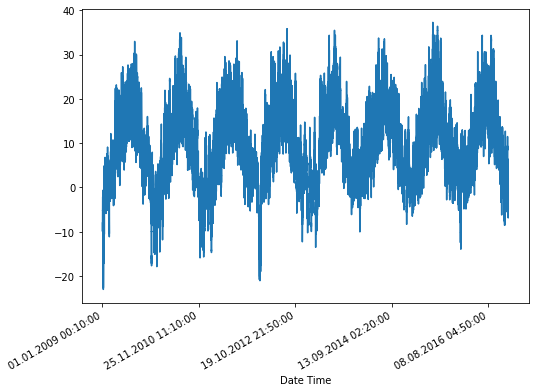

In [10]:
uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [13]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [16]:
def create_time_steps(length):
  return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/kbuilder/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

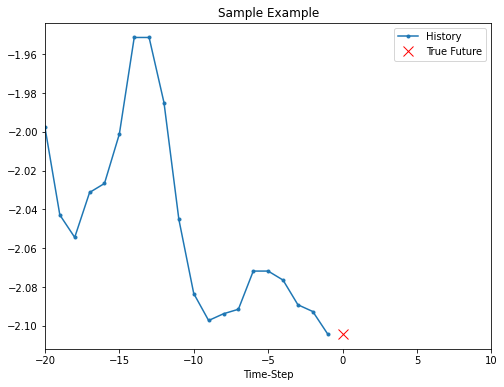

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [19]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/kbuilder/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

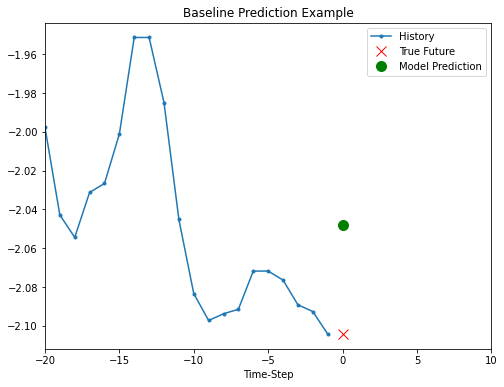

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](images/time_series.png)

You will see the LSTM requires the input shape of the data it is being given.

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10


  1/200 [..............................] - ETA: 0s - loss: 1.0850

 15/200 [=>............................] - ETA: 0s - loss: 0.9427

 30/200 [===>..........................] - ETA: 0s - loss: 0.7959

 45/200 [=====>........................] - ETA: 0s - loss: 0.6958

 60/200 [========>.....................] - ETA: 0s - loss: 0.6271

 74/200 [==========>...................] - ETA: 0s - loss: 0.5842

 89/200 [============>.................] - ETA: 0s - loss: 0.5530

104/200 [==============>...............] - ETA: 0s - loss: 0.5298

119/200 [================>.............] - ETA: 0s - loss: 0.5027

134/200 [===================>..........] - ETA: 0s - loss: 0.4720

150/200 [=====================>........] - ETA: 0s - loss: 0.4398

165/200 [=======================>......] - ETA: 0s - loss: 0.4175

180/200 [==========================>...] - ETA: 0s - loss: 0.4111

195/200 [============================>.] - ETA: 0s - loss: 0.4096

200/200 [==============================] - 1s 6ms/step - loss: 0.4075 - val_loss: 0.1351


Epoch 2/10
  1/200 [..............................] - ETA: 0s - loss: 0.2923

 16/200 [=>............................] - ETA: 0s - loss: 0.2451

 31/200 [===>..........................] - ETA: 0s - loss: 0.1949

 46/200 [=====>........................] - ETA: 0s - loss: 0.1645

 61/200 [========>.....................] - ETA: 0s - loss: 0.1483

 76/200 [==========>...................] - ETA: 0s - loss: 0.1463

 92/200 [============>.................] - ETA: 0s - loss: 0.1513

107/200 [===============>..............] - ETA: 0s - loss: 0.1481

122/200 [=================>............] - ETA: 0s - loss: 0.1411

137/200 [===================>..........] - ETA: 0s - loss: 0.1334

152/200 [=====================>........] - ETA: 0s - loss: 0.1256

167/200 [========================>.....] - ETA: 0s - loss: 0.1204

182/200 [==========================>...] - ETA: 0s - loss: 0.1170

197/200 [============================>.] - ETA: 0s - loss: 0.1127

200/200 [==============================] - 1s 4ms/step - loss: 0.1118 - val_loss: 0.0360


Epoch 3/10
  1/200 [..............................] - ETA: 0s - loss: 0.0513

 16/200 [=>............................] - ETA: 0s - loss: 0.0512

 31/200 [===>..........................] - ETA: 0s - loss: 0.0485

 46/200 [=====>........................] - ETA: 0s - loss: 0.0474

 61/200 [========>.....................] - ETA: 0s - loss: 0.0484

 76/200 [==========>...................] - ETA: 0s - loss: 0.0499

 92/200 [============>.................] - ETA: 0s - loss: 0.0510

107/200 [===============>..............] - ETA: 0s - loss: 0.0516

122/200 [=================>............] - ETA: 0s - loss: 0.0525

137/200 [===================>..........] - ETA: 0s - loss: 0.0525

153/200 [=====================>........] - ETA: 0s - loss: 0.0519

168/200 [========================>.....] - ETA: 0s - loss: 0.0510

183/200 [==========================>...] - ETA: 0s - loss: 0.0499

198/200 [============================>.] - ETA: 0s - loss: 0.0488

200/200 [==============================] - 1s 4ms/step - loss: 0.0490 - val_loss: 0.0289


Epoch 4/10
  1/200 [..............................] - ETA: 0s - loss: 0.0645

 16/200 [=>............................] - ETA: 0s - loss: 0.0666

 31/200 [===>..........................] - ETA: 0s - loss: 0.0576

 46/200 [=====>........................] - ETA: 0s - loss: 0.0517

 61/200 [========>.....................] - ETA: 0s - loss: 0.0494

 76/200 [==========>...................] - ETA: 0s - loss: 0.0480

 91/200 [============>.................] - ETA: 0s - loss: 0.0477

106/200 [==============>...............] - ETA: 0s - loss: 0.0482

121/200 [=================>............] - ETA: 0s - loss: 0.0489

136/200 [===================>..........] - ETA: 0s - loss: 0.0488

151/200 [=====================>........] - ETA: 0s - loss: 0.0481

166/200 [=======================>......] - ETA: 0s - loss: 0.0472

180/200 [==========================>...] - ETA: 0s - loss: 0.0461

194/200 [============================>.] - ETA: 0s - loss: 0.0449

200/200 [==============================] - 1s 4ms/step - loss: 0.0444 - val_loss: 0.0257


Epoch 5/10
  1/200 [..............................] - ETA: 0s - loss: 0.0255

 15/200 [=>............................] - ETA: 0s - loss: 0.0254

 30/200 [===>..........................] - ETA: 0s - loss: 0.0245

 45/200 [=====>........................] - ETA: 0s - loss: 0.0239

 60/200 [========>.....................] - ETA: 0s - loss: 0.0241

 75/200 [==========>...................] - ETA: 0s - loss: 0.0248

 91/200 [============>.................] - ETA: 0s - loss: 0.0256

106/200 [==============>...............] - ETA: 0s - loss: 0.0270

121/200 [=================>............] - ETA: 0s - loss: 0.0288

136/200 [===================>..........] - ETA: 0s - loss: 0.0299

151/200 [=====================>........] - ETA: 0s - loss: 0.0303

166/200 [=======================>......] - ETA: 0s - loss: 0.0304

181/200 [==========================>...] - ETA: 0s - loss: 0.0302

195/200 [============================>.] - ETA: 0s - loss: 0.0300

200/200 [==============================] - 1s 4ms/step - loss: 0.0299 - val_loss: 0.0235


Epoch 6/10
  1/200 [..............................] - ETA: 0s - loss: 0.0247

 15/200 [=>............................] - ETA: 0s - loss: 0.0254

 30/200 [===>..........................] - ETA: 0s - loss: 0.0261

 45/200 [=====>........................] - ETA: 0s - loss: 0.0265

 60/200 [========>.....................] - ETA: 0s - loss: 0.0271

 76/200 [==========>...................] - ETA: 0s - loss: 0.0277

 91/200 [============>.................] - ETA: 0s - loss: 0.0286

106/200 [==============>...............] - ETA: 0s - loss: 0.0297

121/200 [=================>............] - ETA: 0s - loss: 0.0305

133/200 [==================>...........] - ETA: 0s - loss: 0.0309

150/200 [=====================>........] - ETA: 0s - loss: 0.0311

167/200 [========================>.....] - ETA: 0s - loss: 0.0311

177/200 [=========================>....] - ETA: 0s - loss: 0.0315

192/200 [===========================>..] - ETA: 0s - loss: 0.0317

200/200 [==============================] - 1s 4ms/step - loss: 0.0317 - val_loss: 0.0224


Epoch 7/10
  1/200 [..............................] - ETA: 0s - loss: 0.0317

 17/200 [=>............................] - ETA: 0s - loss: 0.0316

 33/200 [===>..........................] - ETA: 0s - loss: 0.0317

 49/200 [======>.......................] - ETA: 0s - loss: 0.0321

 65/200 [========>.....................] - ETA: 0s - loss: 0.0325

 80/200 [===========>..................] - ETA: 0s - loss: 0.0327

 96/200 [=============>................] - ETA: 0s - loss: 0.0323

112/200 [===============>..............] - ETA: 0s - loss: 0.0319

128/200 [==================>...........] - ETA: 0s - loss: 0.0312

143/200 [====================>.........] - ETA: 0s - loss: 0.0307

159/200 [======================>.......] - ETA: 0s - loss: 0.0300

175/200 [=========================>....] - ETA: 0s - loss: 0.0293

191/200 [===========================>..] - ETA: 0s - loss: 0.0288

200/200 [==============================] - 1s 4ms/step - loss: 0.0287 - val_loss: 0.0206


Epoch 8/10
  1/200 [..............................] - ETA: 0s - loss: 0.0229

 16/200 [=>............................] - ETA: 0s - loss: 0.0262

 32/200 [===>..........................] - ETA: 0s - loss: 0.0266

 48/200 [======>.......................] - ETA: 0s - loss: 0.0275

 63/200 [========>.....................] - ETA: 0s - loss: 0.0292

 79/200 [==========>...................] - ETA: 0s - loss: 0.0299

 95/200 [=============>................] - ETA: 0s - loss: 0.0300

110/200 [===============>..............] - ETA: 0s - loss: 0.0298

125/200 [=================>............] - ETA: 0s - loss: 0.0292

141/200 [====================>.........] - ETA: 0s - loss: 0.0285

156/200 [======================>.......] - ETA: 0s - loss: 0.0279

172/200 [========================>.....] - ETA: 0s - loss: 0.0272

187/200 [===========================>..] - ETA: 0s - loss: 0.0267

200/200 [==============================] - 1s 4ms/step - loss: 0.0263 - val_loss: 0.0200


Epoch 9/10
  1/200 [..............................] - ETA: 0s - loss: 0.0245

 16/200 [=>............................] - ETA: 0s - loss: 0.0228

 31/200 [===>..........................] - ETA: 0s - loss: 0.0240

 47/200 [======>.......................] - ETA: 0s - loss: 0.0255

 63/200 [========>.....................] - ETA: 0s - loss: 0.0262

 79/200 [==========>...................] - ETA: 0s - loss: 0.0267

 95/200 [=============>................] - ETA: 0s - loss: 0.0268

110/200 [===============>..............] - ETA: 0s - loss: 0.0268

126/200 [=================>............] - ETA: 0s - loss: 0.0268

142/200 [====================>.........] - ETA: 0s - loss: 0.0264

158/200 [======================>.......] - ETA: 0s - loss: 0.0260

174/200 [=========================>....] - ETA: 0s - loss: 0.0257

190/200 [===========================>..] - ETA: 0s - loss: 0.0256

200/200 [==============================] - 1s 4ms/step - loss: 0.0254 - val_loss: 0.0182


Epoch 10/10
  1/200 [..............................] - ETA: 0s - loss: 0.0220

 17/200 [=>............................] - ETA: 0s - loss: 0.0221

 33/200 [===>..........................] - ETA: 0s - loss: 0.0227

 49/200 [======>.......................] - ETA: 0s - loss: 0.0231

 65/200 [========>.....................] - ETA: 0s - loss: 0.0240

 81/200 [===========>..................] - ETA: 0s - loss: 0.0245

 96/200 [=============>................] - ETA: 0s - loss: 0.0252

112/200 [===============>..............] - ETA: 0s - loss: 0.0254

128/200 [==================>...........] - ETA: 0s - loss: 0.0253

144/200 [====================>.........] - ETA: 0s - loss: 0.0250

160/200 [=======================>......] - ETA: 0s - loss: 0.0244

176/200 [=========================>....] - ETA: 0s - loss: 0.0237

192/200 [===========================>..] - ETA: 0s - loss: 0.0231

200/200 [==============================] - 1s 4ms/step - loss: 0.0228 - val_loss: 0.0174


#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

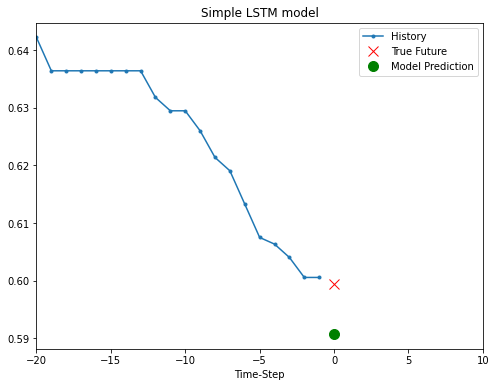

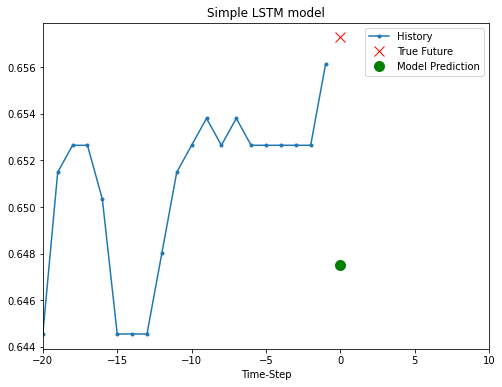

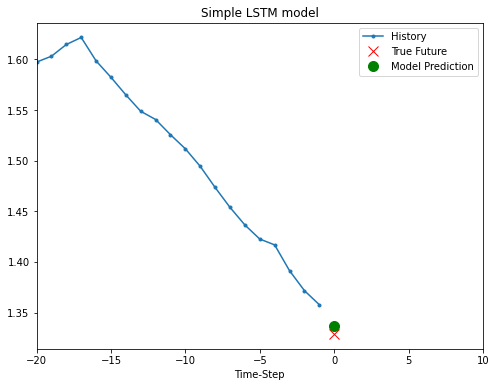

In [25]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd542d93550>,
      dtype=object)

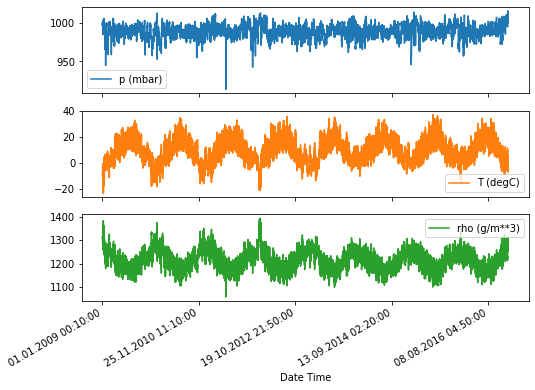

In [28]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as above, however, here it samples the past observation based on the step size given.

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [36]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10


  1/200 [..............................] - ETA: 0s - loss: 0.7783

  7/200 [>.............................] - ETA: 1s - loss: 0.5101

 14/200 [=>............................] - ETA: 1s - loss: 0.4240

 21/200 [==>...........................] - ETA: 1s - loss: 0.4028

 28/200 [===>..........................] - ETA: 1s - loss: 0.3969

 35/200 [====>.........................] - ETA: 1s - loss: 0.3926

 42/200 [=====>........................] - ETA: 1s - loss: 0.3882

 50/200 [======>.......................] - ETA: 1s - loss: 0.3845

 57/200 [=======>......................] - ETA: 1s - loss: 0.3783

 64/200 [========>.....................] - ETA: 1s - loss: 0.3753

 72/200 [=========>....................] - ETA: 0s - loss: 0.3703

 79/200 [==========>...................] - ETA: 0s - loss: 0.3662

 87/200 [============>.................] - ETA: 0s - loss: 0.3595

 94/200 [=============>................] - ETA: 0s - loss: 0.3538

101/200 [==============>...............] - ETA: 0s - loss: 0.3481

108/200 [===============>..............] - ETA: 0s - loss: 0.3425

115/200 [================>.............] - ETA: 0s - loss: 0.3378

122/200 [=================>............] - ETA: 0s - loss: 0.3343

129/200 [==================>...........] - ETA: 0s - loss: 0.3311

136/200 [===================>..........] - ETA: 0s - loss: 0.3281

143/200 [====================>.........] - ETA: 0s - loss: 0.3248

150/200 [=====================>........] - ETA: 0s - loss: 0.3215

157/200 [======================>.......] - ETA: 0s - loss: 0.3188

164/200 [=======================>......] - ETA: 0s - loss: 0.3173

171/200 [========================>.....] - ETA: 0s - loss: 0.3160

178/200 [=========================>....] - ETA: 0s - loss: 0.3143

186/200 [==========================>...] - ETA: 0s - loss: 0.3123

193/200 [===========================>..] - ETA: 0s - loss: 0.3102

200/200 [==============================] - ETA: 0s - loss: 0.3090

200/200 [==============================] - 2s 11ms/step - loss: 0.3090 - val_loss: 0.2646


Epoch 2/10
  1/200 [..............................] - ETA: 0s - loss: 0.2651

  8/200 [>.............................] - ETA: 1s - loss: 0.2719

 15/200 [=>............................] - ETA: 1s - loss: 0.2779

 22/200 [==>...........................] - ETA: 1s - loss: 0.2766

 29/200 [===>..........................] - ETA: 1s - loss: 0.2754

 37/200 [====>.........................] - ETA: 1s - loss: 0.2759

 45/200 [=====>........................] - ETA: 1s - loss: 0.2748

 53/200 [======>.......................] - ETA: 1s - loss: 0.2735

 60/200 [========>.....................] - ETA: 0s - loss: 0.2756

 67/200 [=========>....................] - ETA: 0s - loss: 0.2747

 74/200 [==========>...................] - ETA: 0s - loss: 0.2733

 81/200 [===========>..................] - ETA: 0s - loss: 0.2729

 88/200 [============>.................] - ETA: 0s - loss: 0.2721

 95/200 [=============>................] - ETA: 0s - loss: 0.2706

102/200 [==============>...............] - ETA: 0s - loss: 0.2691

109/200 [===============>..............] - ETA: 0s - loss: 0.2678

116/200 [================>.............] - ETA: 0s - loss: 0.2660

123/200 [=================>............] - ETA: 0s - loss: 0.2641

130/200 [==================>...........] - ETA: 0s - loss: 0.2629

137/200 [===================>..........] - ETA: 0s - loss: 0.2616

144/200 [====================>.........] - ETA: 0s - loss: 0.2611

151/200 [=====================>........] - ETA: 0s - loss: 0.2607

158/200 [======================>.......] - ETA: 0s - loss: 0.2604

165/200 [=======================>......] - ETA: 0s - loss: 0.2598

172/200 [========================>.....] - ETA: 0s - loss: 0.2602

179/200 [=========================>....] - ETA: 0s - loss: 0.2613

186/200 [==========================>...] - ETA: 0s - loss: 0.2617

193/200 [===========================>..] - ETA: 0s - loss: 0.2620

200/200 [==============================] - ETA: 0s - loss: 0.2624

200/200 [==============================] - 2s 9ms/step - loss: 0.2624 - val_loss: 0.2435


Epoch 3/10
  1/200 [..............................] - ETA: 0s - loss: 0.2630

  9/200 [>.............................] - ETA: 1s - loss: 0.2768

 17/200 [=>............................] - ETA: 1s - loss: 0.2706

 24/200 [==>...........................] - ETA: 1s - loss: 0.2695

 32/200 [===>..........................] - ETA: 1s - loss: 0.2725

 39/200 [====>.........................] - ETA: 1s - loss: 0.2725

 46/200 [=====>........................] - ETA: 1s - loss: 0.2721

 53/200 [======>.......................] - ETA: 1s - loss: 0.2691

 60/200 [========>.....................] - ETA: 0s - loss: 0.2679

 67/200 [=========>....................] - ETA: 0s - loss: 0.2681

 74/200 [==========>...................] - ETA: 0s - loss: 0.2681

 81/200 [===========>..................] - ETA: 0s - loss: 0.2671

 88/200 [============>.................] - ETA: 0s - loss: 0.2666

 95/200 [=============>................] - ETA: 0s - loss: 0.2657

103/200 [==============>...............] - ETA: 0s - loss: 0.2644

110/200 [===============>..............] - ETA: 0s - loss: 0.2638

117/200 [================>.............] - ETA: 0s - loss: 0.2633

124/200 [=================>............] - ETA: 0s - loss: 0.2626

131/200 [==================>...........] - ETA: 0s - loss: 0.2624

139/200 [===================>..........] - ETA: 0s - loss: 0.2625

146/200 [====================>.........] - ETA: 0s - loss: 0.2627

153/200 [=====================>........] - ETA: 0s - loss: 0.2626

160/200 [=======================>......] - ETA: 0s - loss: 0.2624

168/200 [========================>.....] - ETA: 0s - loss: 0.2624

175/200 [=========================>....] - ETA: 0s - loss: 0.2623

183/200 [==========================>...] - ETA: 0s - loss: 0.2621

191/200 [===========================>..] - ETA: 0s - loss: 0.2616

198/200 [============================>.] - ETA: 0s - loss: 0.2616

200/200 [==============================] - 2s 9ms/step - loss: 0.2616 - val_loss: 0.2472


Epoch 4/10
  1/200 [..............................] - ETA: 0s - loss: 0.2607

  8/200 [>.............................] - ETA: 1s - loss: 0.2628

 15/200 [=>............................] - ETA: 1s - loss: 0.2599

 22/200 [==>...........................] - ETA: 1s - loss: 0.2579

 29/200 [===>..........................] - ETA: 1s - loss: 0.2576

 36/200 [====>.........................] - ETA: 1s - loss: 0.2585

 43/200 [=====>........................] - ETA: 1s - loss: 0.2617

 50/200 [======>.......................] - ETA: 1s - loss: 0.2631

 57/200 [=======>......................] - ETA: 1s - loss: 0.2671

 64/200 [========>.....................] - ETA: 0s - loss: 0.2683

 71/200 [=========>....................] - ETA: 0s - loss: 0.2684

 78/200 [==========>...................] - ETA: 0s - loss: 0.2689

 86/200 [===========>..................] - ETA: 0s - loss: 0.2689

 93/200 [============>.................] - ETA: 0s - loss: 0.2682

101/200 [==============>...............] - ETA: 0s - loss: 0.2673

108/200 [===============>..............] - ETA: 0s - loss: 0.2658

115/200 [================>.............] - ETA: 0s - loss: 0.2651

122/200 [=================>............] - ETA: 0s - loss: 0.2633

130/200 [==================>...........] - ETA: 0s - loss: 0.2629

138/200 [===================>..........] - ETA: 0s - loss: 0.2621

145/200 [====================>.........] - ETA: 0s - loss: 0.2617

152/200 [=====================>........] - ETA: 0s - loss: 0.2616

159/200 [======================>.......] - ETA: 0s - loss: 0.2612

166/200 [=======================>......] - ETA: 0s - loss: 0.2609

174/200 [=========================>....] - ETA: 0s - loss: 0.2599

181/200 [==========================>...] - ETA: 0s - loss: 0.2590

188/200 [===========================>..] - ETA: 0s - loss: 0.2583

195/200 [============================>.] - ETA: 0s - loss: 0.2572

200/200 [==============================] - 2s 9ms/step - loss: 0.2567 - val_loss: 0.2442


Epoch 5/10
  1/200 [..............................] - ETA: 0s - loss: 0.2353

  8/200 [>.............................] - ETA: 1s - loss: 0.2250

 15/200 [=>............................] - ETA: 1s - loss: 0.2189

 22/200 [==>...........................] - ETA: 1s - loss: 0.2160

 29/200 [===>..........................] - ETA: 1s - loss: 0.2158

 36/200 [====>.........................] - ETA: 1s - loss: 0.2143

 43/200 [=====>........................] - ETA: 1s - loss: 0.2139

 51/200 [======>.......................] - ETA: 1s - loss: 0.2161

 59/200 [=======>......................] - ETA: 1s - loss: 0.2167

 67/200 [=========>....................] - ETA: 0s - loss: 0.2175

 75/200 [==========>...................] - ETA: 0s - loss: 0.2174

 82/200 [===========>..................] - ETA: 0s - loss: 0.2191

 89/200 [============>.................] - ETA: 0s - loss: 0.2194

 96/200 [=============>................] - ETA: 0s - loss: 0.2189

103/200 [==============>...............] - ETA: 0s - loss: 0.2188

110/200 [===============>..............] - ETA: 0s - loss: 0.2199

117/200 [================>.............] - ETA: 0s - loss: 0.2201

124/200 [=================>............] - ETA: 0s - loss: 0.2210

132/200 [==================>...........] - ETA: 0s - loss: 0.2209

139/200 [===================>..........] - ETA: 0s - loss: 0.2209

147/200 [=====================>........] - ETA: 0s - loss: 0.2208

154/200 [======================>.......] - ETA: 0s - loss: 0.2217

162/200 [=======================>......] - ETA: 0s - loss: 0.2231

169/200 [========================>.....] - ETA: 0s - loss: 0.2242

176/200 [=========================>....] - ETA: 0s - loss: 0.2247

183/200 [==========================>...] - ETA: 0s - loss: 0.2252

190/200 [===========================>..] - ETA: 0s - loss: 0.2258

197/200 [============================>.] - ETA: 0s - loss: 0.2262

200/200 [==============================] - 2s 9ms/step - loss: 0.2263 - val_loss: 0.2346


Epoch 6/10
  1/200 [..............................] - ETA: 0s - loss: 0.2300

  8/200 [>.............................] - ETA: 1s - loss: 0.2465

 16/200 [=>............................] - ETA: 1s - loss: 0.2435

 23/200 [==>...........................] - ETA: 1s - loss: 0.2412

 30/200 [===>..........................] - ETA: 1s - loss: 0.2427

 37/200 [====>.........................] - ETA: 1s - loss: 0.2455

 44/200 [=====>........................] - ETA: 1s - loss: 0.2488

 51/200 [======>.......................] - ETA: 1s - loss: 0.2501

 58/200 [=======>......................] - ETA: 1s - loss: 0.2509

 65/200 [========>.....................] - ETA: 0s - loss: 0.2512

 72/200 [=========>....................] - ETA: 0s - loss: 0.2516

 79/200 [==========>...................] - ETA: 0s - loss: 0.2508

 86/200 [===========>..................] - ETA: 0s - loss: 0.2503

 93/200 [============>.................] - ETA: 0s - loss: 0.2503

100/200 [==============>...............] - ETA: 0s - loss: 0.2500

107/200 [===============>..............] - ETA: 0s - loss: 0.2498

114/200 [================>.............] - ETA: 0s - loss: 0.2496

121/200 [=================>............] - ETA: 0s - loss: 0.2484

128/200 [==================>...........] - ETA: 0s - loss: 0.2475

133/200 [==================>...........] - ETA: 0s - loss: 0.2467

141/200 [====================>.........] - ETA: 0s - loss: 0.2450

149/200 [=====================>........] - ETA: 0s - loss: 0.2434

157/200 [======================>.......] - ETA: 0s - loss: 0.2423

165/200 [=======================>......] - ETA: 0s - loss: 0.2406

171/200 [========================>.....] - ETA: 0s - loss: 0.2404

179/200 [=========================>....] - ETA: 0s - loss: 0.2409

187/200 [===========================>..] - ETA: 0s - loss: 0.2411

195/200 [============================>.] - ETA: 0s - loss: 0.2417

200/200 [==============================] - 2s 9ms/step - loss: 0.2419 - val_loss: 0.2643


Epoch 7/10
  1/200 [..............................] - ETA: 0s - loss: 0.2428

  9/200 [>.............................] - ETA: 1s - loss: 0.2460

 17/200 [=>............................] - ETA: 1s - loss: 0.2469

 25/200 [==>...........................] - ETA: 1s - loss: 0.2495

 33/200 [===>..........................] - ETA: 1s - loss: 0.2496

 41/200 [=====>........................] - ETA: 1s - loss: 0.2497

 49/200 [======>.......................] - ETA: 0s - loss: 0.2476

 57/200 [=======>......................] - ETA: 0s - loss: 0.2451

 65/200 [========>.....................] - ETA: 0s - loss: 0.2442

 73/200 [=========>....................] - ETA: 0s - loss: 0.2425

 81/200 [===========>..................] - ETA: 0s - loss: 0.2414

 89/200 [============>.................] - ETA: 0s - loss: 0.2406

 97/200 [=============>................] - ETA: 0s - loss: 0.2402

105/200 [==============>...............] - ETA: 0s - loss: 0.2404

113/200 [===============>..............] - ETA: 0s - loss: 0.2396

121/200 [=================>............] - ETA: 0s - loss: 0.2386

129/200 [==================>...........] - ETA: 0s - loss: 0.2382

137/200 [===================>..........] - ETA: 0s - loss: 0.2384

145/200 [====================>.........] - ETA: 0s - loss: 0.2396

153/200 [=====================>........] - ETA: 0s - loss: 0.2401

161/200 [=======================>......] - ETA: 0s - loss: 0.2405

169/200 [========================>.....] - ETA: 0s - loss: 0.2401

177/200 [=========================>....] - ETA: 0s - loss: 0.2404

185/200 [==========================>...] - ETA: 0s - loss: 0.2408

193/200 [===========================>..] - ETA: 0s - loss: 0.2409

200/200 [==============================] - 2s 9ms/step - loss: 0.2411 - val_loss: 0.2577


Epoch 8/10
  1/200 [..............................] - ETA: 0s - loss: 0.2697

  9/200 [>.............................] - ETA: 1s - loss: 0.2588

 17/200 [=>............................] - ETA: 1s - loss: 0.2542

 25/200 [==>...........................] - ETA: 1s - loss: 0.2550

 33/200 [===>..........................] - ETA: 1s - loss: 0.2541

 41/200 [=====>........................] - ETA: 1s - loss: 0.2498

 49/200 [======>.......................] - ETA: 0s - loss: 0.2487

 57/200 [=======>......................] - ETA: 0s - loss: 0.2479

 65/200 [========>.....................] - ETA: 0s - loss: 0.2458

 73/200 [=========>....................] - ETA: 0s - loss: 0.2434

 81/200 [===========>..................] - ETA: 0s - loss: 0.2417

 89/200 [============>.................] - ETA: 0s - loss: 0.2397

 97/200 [=============>................] - ETA: 0s - loss: 0.2378

105/200 [==============>...............] - ETA: 0s - loss: 0.2361

113/200 [===============>..............] - ETA: 0s - loss: 0.2362

121/200 [=================>............] - ETA: 0s - loss: 0.2364

129/200 [==================>...........] - ETA: 0s - loss: 0.2363

137/200 [===================>..........] - ETA: 0s - loss: 0.2360

145/200 [====================>.........] - ETA: 0s - loss: 0.2367

153/200 [=====================>........] - ETA: 0s - loss: 0.2376

161/200 [=======================>......] - ETA: 0s - loss: 0.2381

169/200 [========================>.....] - ETA: 0s - loss: 0.2387

177/200 [=========================>....] - ETA: 0s - loss: 0.2395

185/200 [==========================>...] - ETA: 0s - loss: 0.2401

193/200 [===========================>..] - ETA: 0s - loss: 0.2406

200/200 [==============================] - 2s 9ms/step - loss: 0.2410 - val_loss: 0.2388


Epoch 9/10
  1/200 [..............................] - ETA: 0s - loss: 0.2677

  9/200 [>.............................] - ETA: 1s - loss: 0.2591

 17/200 [=>............................] - ETA: 1s - loss: 0.2525

 25/200 [==>...........................] - ETA: 1s - loss: 0.2514

 33/200 [===>..........................] - ETA: 1s - loss: 0.2531

 41/200 [=====>........................] - ETA: 1s - loss: 0.2525

 49/200 [======>.......................] - ETA: 0s - loss: 0.2519

 57/200 [=======>......................] - ETA: 0s - loss: 0.2498

 65/200 [========>.....................] - ETA: 0s - loss: 0.2482

 73/200 [=========>....................] - ETA: 0s - loss: 0.2476

 81/200 [===========>..................] - ETA: 0s - loss: 0.2472

 89/200 [============>.................] - ETA: 0s - loss: 0.2477

 97/200 [=============>................] - ETA: 0s - loss: 0.2467

105/200 [==============>...............] - ETA: 0s - loss: 0.2466

113/200 [===============>..............] - ETA: 0s - loss: 0.2476

121/200 [=================>............] - ETA: 0s - loss: 0.2470

129/200 [==================>...........] - ETA: 0s - loss: 0.2464

137/200 [===================>..........] - ETA: 0s - loss: 0.2468

145/200 [====================>.........] - ETA: 0s - loss: 0.2468

153/200 [=====================>........] - ETA: 0s - loss: 0.2469

161/200 [=======================>......] - ETA: 0s - loss: 0.2463

169/200 [========================>.....] - ETA: 0s - loss: 0.2461

177/200 [=========================>....] - ETA: 0s - loss: 0.2458

185/200 [==========================>...] - ETA: 0s - loss: 0.2454

193/200 [===========================>..] - ETA: 0s - loss: 0.2450

200/200 [==============================] - 2s 9ms/step - loss: 0.2447 - val_loss: 0.2485


Epoch 10/10
  1/200 [..............................] - ETA: 0s - loss: 0.2300

  8/200 [>.............................] - ETA: 1s - loss: 0.2536

 16/200 [=>............................] - ETA: 1s - loss: 0.2535

 24/200 [==>...........................] - ETA: 1s - loss: 0.2584

 32/200 [===>..........................] - ETA: 1s - loss: 0.2595

 40/200 [=====>........................] - ETA: 1s - loss: 0.2597

 48/200 [======>.......................] - ETA: 1s - loss: 0.2603

 56/200 [=======>......................] - ETA: 0s - loss: 0.2601

 64/200 [========>.....................] - ETA: 0s - loss: 0.2578

 72/200 [=========>....................] - ETA: 0s - loss: 0.2561

 80/200 [===========>..................] - ETA: 0s - loss: 0.2541

 88/200 [============>.................] - ETA: 0s - loss: 0.2518

 96/200 [=============>................] - ETA: 0s - loss: 0.2505

104/200 [==============>...............] - ETA: 0s - loss: 0.2489

112/200 [===============>..............] - ETA: 0s - loss: 0.2487

120/200 [=================>............] - ETA: 0s - loss: 0.2485

128/200 [==================>...........] - ETA: 0s - loss: 0.2482

136/200 [===================>..........] - ETA: 0s - loss: 0.2478

144/200 [====================>.........] - ETA: 0s - loss: 0.2472

152/200 [=====================>........] - ETA: 0s - loss: 0.2464

160/200 [=======================>......] - ETA: 0s - loss: 0.2454

168/200 [========================>.....] - ETA: 0s - loss: 0.2443

176/200 [=========================>....] - ETA: 0s - loss: 0.2429

184/200 [==========================>...] - ETA: 0s - loss: 0.2413

192/200 [===========================>..] - ETA: 0s - loss: 0.2399

200/200 [==============================] - ETA: 0s - loss: 0.2388

200/200 [==============================] - 2s 9ms/step - loss: 0.2388 - val_loss: 0.2422


In [38]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

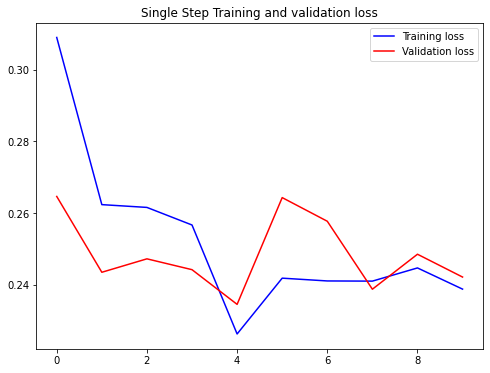

In [39]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

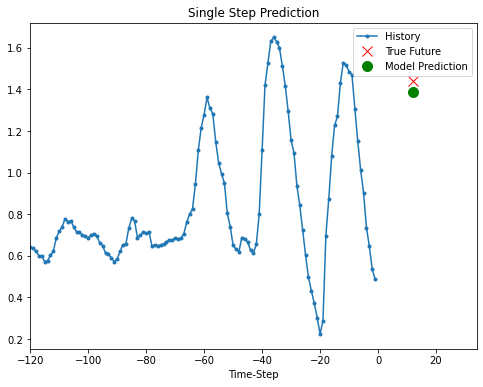

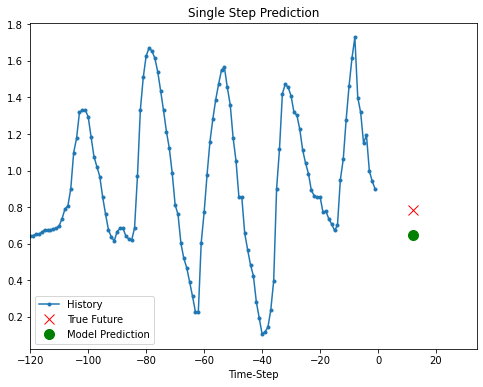

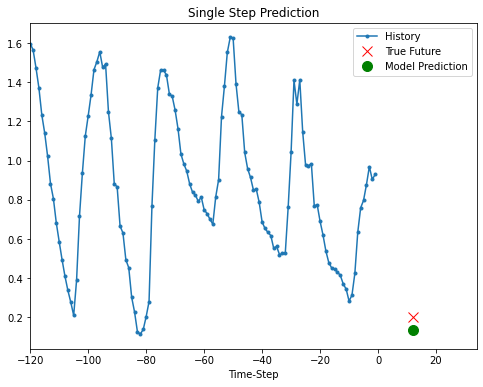

In [40]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [41]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [42]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [43]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [44]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

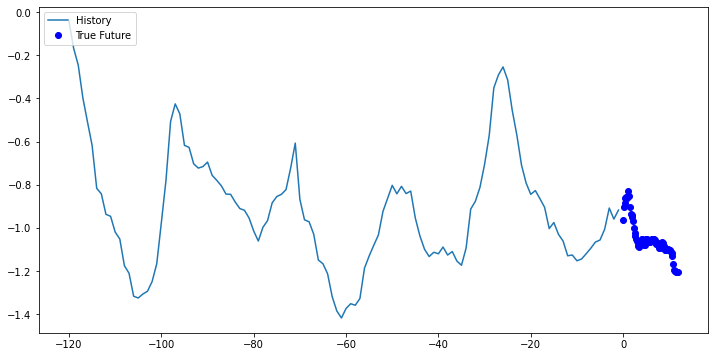

In [45]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [46]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [47]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [48]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10


  1/200 [..............................] - ETA: 0s - loss: 1.1390

  2/200 [..............................] - ETA: 15s - loss: 1.1100

  3/200 [..............................] - ETA: 19s - loss: 1.0828

  4/200 [..............................] - ETA: 21s - loss: 1.0768

  5/200 [..............................] - ETA: 22s - loss: 1.0582

  6/200 [..............................] - ETA: 22s - loss: 1.0338

  7/200 [>.............................] - ETA: 23s - loss: 1.0154

  8/200 [>.............................] - ETA: 24s - loss: 0.9967

  9/200 [>.............................] - ETA: 24s - loss: 0.9822

 10/200 [>.............................] - ETA: 24s - loss: 0.9675

 11/200 [>.............................] - ETA: 24s - loss: 0.9568

 12/200 [>.............................] - ETA: 24s - loss: 0.9439

 13/200 [>.............................] - ETA: 24s - loss: 0.9289

 14/200 [=>............................] - ETA: 24s - loss: 0.9144

 15/200 [=>............................] - ETA: 24s - loss: 0.9100

 16/200 [=>............................] - ETA: 24s - loss: 0.8994

 17/200 [=>............................] - ETA: 24s - loss: 0.8892

 18/200 [=>............................] - ETA: 24s - loss: 0.8796

 19/200 [=>............................] - ETA: 24s - loss: 0.8683

 20/200 [==>...........................] - ETA: 24s - loss: 0.8573

 21/200 [==>...........................] - ETA: 24s - loss: 0.8472

 22/200 [==>...........................] - ETA: 24s - loss: 0.8381

 23/200 [==>...........................] - ETA: 24s - loss: 0.8290

 24/200 [==>...........................] - ETA: 23s - loss: 0.8204

 25/200 [==>...........................] - ETA: 23s - loss: 0.8121

 26/200 [==>...........................] - ETA: 23s - loss: 0.8035

 27/200 [===>..........................] - ETA: 23s - loss: 0.7951

 28/200 [===>..........................] - ETA: 23s - loss: 0.7869

 29/200 [===>..........................] - ETA: 23s - loss: 0.7793

 30/200 [===>..........................] - ETA: 23s - loss: 0.7710

 31/200 [===>..........................] - ETA: 23s - loss: 0.7639

 32/200 [===>..........................] - ETA: 23s - loss: 0.7563

 33/200 [===>..........................] - ETA: 22s - loss: 0.7491

 34/200 [====>.........................] - ETA: 22s - loss: 0.7426

 35/200 [====>.........................] - ETA: 22s - loss: 0.7354

 36/200 [====>.........................] - ETA: 22s - loss: 0.7294

 37/200 [====>.........................] - ETA: 22s - loss: 0.7232

 38/200 [====>.........................] - ETA: 22s - loss: 0.7182

 39/200 [====>.........................] - ETA: 22s - loss: 0.7136

 40/200 [=====>........................] - ETA: 22s - loss: 0.7086

 41/200 [=====>........................] - ETA: 21s - loss: 0.7043

 42/200 [=====>........................] - ETA: 21s - loss: 0.7002

 43/200 [=====>........................] - ETA: 21s - loss: 0.6962

 44/200 [=====>........................] - ETA: 21s - loss: 0.6926

 45/200 [=====>........................] - ETA: 21s - loss: 0.6889

 46/200 [=====>........................] - ETA: 21s - loss: 0.6847

 47/200 [======>.......................] - ETA: 21s - loss: 0.6806

 48/200 [======>.......................] - ETA: 21s - loss: 0.6771

 49/200 [======>.......................] - ETA: 21s - loss: 0.6735

 50/200 [======>.......................] - ETA: 20s - loss: 0.6698

 51/200 [======>.......................] - ETA: 20s - loss: 0.6663

 52/200 [======>.......................] - ETA: 20s - loss: 0.6632

 53/200 [======>.......................] - ETA: 20s - loss: 0.6607

 54/200 [=======>......................] - ETA: 20s - loss: 0.6578

 55/200 [=======>......................] - ETA: 20s - loss: 0.6546

 56/200 [=======>......................] - ETA: 20s - loss: 0.6518

 57/200 [=======>......................] - ETA: 20s - loss: 0.6491

 58/200 [=======>......................] - ETA: 19s - loss: 0.6463

 59/200 [=======>......................] - ETA: 19s - loss: 0.6439

 60/200 [========>.....................] - ETA: 19s - loss: 0.6414

 61/200 [========>.....................] - ETA: 19s - loss: 0.6391

 62/200 [========>.....................] - ETA: 19s - loss: 0.6372

 63/200 [========>.....................] - ETA: 19s - loss: 0.6352

 64/200 [========>.....................] - ETA: 19s - loss: 0.6337

 65/200 [========>.....................] - ETA: 19s - loss: 0.6327

 66/200 [========>.....................] - ETA: 18s - loss: 0.6310

 67/200 [=========>....................] - ETA: 18s - loss: 0.6292

 68/200 [=========>....................] - ETA: 18s - loss: 0.6277

 69/200 [=========>....................] - ETA: 18s - loss: 0.6260

 70/200 [=========>....................] - ETA: 18s - loss: 0.6248

 71/200 [=========>....................] - ETA: 18s - loss: 0.6232

 72/200 [=========>....................] - ETA: 18s - loss: 0.6213

 73/200 [=========>....................] - ETA: 17s - loss: 0.6203

 74/200 [==========>...................] - ETA: 17s - loss: 0.6198

 75/200 [==========>...................] - ETA: 17s - loss: 0.6188

 76/200 [==========>...................] - ETA: 17s - loss: 0.6179

 77/200 [==========>...................] - ETA: 17s - loss: 0.6171

 78/200 [==========>...................] - ETA: 17s - loss: 0.6162

 79/200 [==========>...................] - ETA: 17s - loss: 0.6154

 80/200 [===========>..................] - ETA: 17s - loss: 0.6147

 81/200 [===========>..................] - ETA: 16s - loss: 0.6138

 82/200 [===========>..................] - ETA: 16s - loss: 0.6126

 83/200 [===========>..................] - ETA: 16s - loss: 0.6120

 84/200 [===========>..................] - ETA: 16s - loss: 0.6118

 85/200 [===========>..................] - ETA: 16s - loss: 0.6113

 86/200 [===========>..................] - ETA: 16s - loss: 0.6106

 87/200 [============>.................] - ETA: 16s - loss: 0.6102

 88/200 [============>.................] - ETA: 15s - loss: 0.6098

 89/200 [============>.................] - ETA: 15s - loss: 0.6095

 90/200 [============>.................] - ETA: 15s - loss: 0.6092

 91/200 [============>.................] - ETA: 15s - loss: 0.6090

 92/200 [============>.................] - ETA: 15s - loss: 0.6092

 93/200 [============>.................] - ETA: 15s - loss: 0.6089

 94/200 [=============>................] - ETA: 15s - loss: 0.6085

 95/200 [=============>................] - ETA: 14s - loss: 0.6081

 96/200 [=============>................] - ETA: 14s - loss: 0.6080

 97/200 [=============>................] - ETA: 14s - loss: 0.6079

 98/200 [=============>................] - ETA: 14s - loss: 0.6076

 99/200 [=============>................] - ETA: 14s - loss: 0.6073

100/200 [==============>...............] - ETA: 14s - loss: 0.6069

101/200 [==============>...............] - ETA: 14s - loss: 0.6063

102/200 [==============>...............] - ETA: 13s - loss: 0.6059

103/200 [==============>...............] - ETA: 13s - loss: 0.6052

104/200 [==============>...............] - ETA: 13s - loss: 0.6044

105/200 [==============>...............] - ETA: 13s - loss: 0.6037

106/200 [==============>...............] - ETA: 13s - loss: 0.6031

107/200 [===============>..............] - ETA: 13s - loss: 0.6024

108/200 [===============>..............] - ETA: 13s - loss: 0.6018

109/200 [===============>..............] - ETA: 12s - loss: 0.6014

110/200 [===============>..............] - ETA: 12s - loss: 0.6005

111/200 [===============>..............] - ETA: 12s - loss: 0.5999

112/200 [===============>..............] - ETA: 12s - loss: 0.5991

113/200 [===============>..............] - ETA: 12s - loss: 0.5983

114/200 [================>.............] - ETA: 12s - loss: 0.5974

115/200 [================>.............] - ETA: 12s - loss: 0.5964

116/200 [================>.............] - ETA: 11s - loss: 0.5955

117/200 [================>.............] - ETA: 11s - loss: 0.5947

118/200 [================>.............] - ETA: 11s - loss: 0.5938

119/200 [================>.............] - ETA: 11s - loss: 0.5928

120/200 [=================>............] - ETA: 11s - loss: 0.5920

121/200 [=================>............] - ETA: 11s - loss: 0.5907

122/200 [=================>............] - ETA: 11s - loss: 0.5897

123/200 [=================>............] - ETA: 10s - loss: 0.5885

124/200 [=================>............] - ETA: 10s - loss: 0.5874

125/200 [=================>............] - ETA: 10s - loss: 0.5863

126/200 [=================>............] - ETA: 10s - loss: 0.5851

127/200 [==================>...........] - ETA: 10s - loss: 0.5840

128/200 [==================>...........] - ETA: 10s - loss: 0.5827

129/200 [==================>...........] - ETA: 10s - loss: 0.5814

130/200 [==================>...........] - ETA: 9s - loss: 0.5805 

131/200 [==================>...........] - ETA: 9s - loss: 0.5793

132/200 [==================>...........] - ETA: 9s - loss: 0.5782

133/200 [==================>...........] - ETA: 9s - loss: 0.5769

134/200 [===================>..........] - ETA: 9s - loss: 0.5757

135/200 [===================>..........] - ETA: 9s - loss: 0.5743

136/200 [===================>..........] - ETA: 9s - loss: 0.5730

137/200 [===================>..........] - ETA: 8s - loss: 0.5719

138/200 [===================>..........] - ETA: 8s - loss: 0.5706

139/200 [===================>..........] - ETA: 8s - loss: 0.5691

140/200 [====================>.........] - ETA: 8s - loss: 0.5679

141/200 [====================>.........] - ETA: 8s - loss: 0.5664

142/200 [====================>.........] - ETA: 8s - loss: 0.5651

143/200 [====================>.........] - ETA: 8s - loss: 0.5636

144/200 [====================>.........] - ETA: 7s - loss: 0.5620

145/200 [====================>.........] - ETA: 7s - loss: 0.5605

146/200 [====================>.........] - ETA: 7s - loss: 0.5591

147/200 [=====================>........] - ETA: 7s - loss: 0.5575

148/200 [=====================>........] - ETA: 7s - loss: 0.5560

149/200 [=====================>........] - ETA: 7s - loss: 0.5545

150/200 [=====================>........] - ETA: 7s - loss: 0.5531

151/200 [=====================>........] - ETA: 6s - loss: 0.5516

152/200 [=====================>........] - ETA: 6s - loss: 0.5502

153/200 [=====================>........] - ETA: 6s - loss: 0.5489

154/200 [======================>.......] - ETA: 6s - loss: 0.5476

155/200 [======================>.......] - ETA: 6s - loss: 0.5461

156/200 [======================>.......] - ETA: 6s - loss: 0.5448

157/200 [======================>.......] - ETA: 6s - loss: 0.5435

158/200 [======================>.......] - ETA: 5s - loss: 0.5422

159/200 [======================>.......] - ETA: 5s - loss: 0.5412

160/200 [=======================>......] - ETA: 5s - loss: 0.5399

161/200 [=======================>......] - ETA: 5s - loss: 0.5386

162/200 [=======================>......] - ETA: 5s - loss: 0.5372

163/200 [=======================>......] - ETA: 5s - loss: 0.5361

164/200 [=======================>......] - ETA: 5s - loss: 0.5351

165/200 [=======================>......] - ETA: 4s - loss: 0.5342

166/200 [=======================>......] - ETA: 4s - loss: 0.5332

167/200 [========================>.....] - ETA: 4s - loss: 0.5320

168/200 [========================>.....] - ETA: 4s - loss: 0.5307

169/200 [========================>.....] - ETA: 4s - loss: 0.5296

170/200 [========================>.....] - ETA: 4s - loss: 0.5282

171/200 [========================>.....] - ETA: 4s - loss: 0.5272

172/200 [========================>.....] - ETA: 3s - loss: 0.5263

173/200 [========================>.....] - ETA: 3s - loss: 0.5253

174/200 [=========================>....] - ETA: 3s - loss: 0.5240

175/200 [=========================>....] - ETA: 3s - loss: 0.5228

176/200 [=========================>....] - ETA: 3s - loss: 0.5216

177/200 [=========================>....] - ETA: 3s - loss: 0.5203

178/200 [=========================>....] - ETA: 3s - loss: 0.5189

179/200 [=========================>....] - ETA: 2s - loss: 0.5176

180/200 [==========================>...] - ETA: 2s - loss: 0.5165

181/200 [==========================>...] - ETA: 2s - loss: 0.5152

182/200 [==========================>...] - ETA: 2s - loss: 0.5141

183/200 [==========================>...] - ETA: 2s - loss: 0.5131

184/200 [==========================>...] - ETA: 2s - loss: 0.5119

185/200 [==========================>...] - ETA: 2s - loss: 0.5109

186/200 [==========================>...] - ETA: 1s - loss: 0.5097

187/200 [===========================>..] - ETA: 1s - loss: 0.5085

188/200 [===========================>..] - ETA: 1s - loss: 0.5075

189/200 [===========================>..] - ETA: 1s - loss: 0.5068

190/200 [===========================>..] - ETA: 1s - loss: 0.5057

191/200 [===========================>..] - ETA: 1s - loss: 0.5046

192/200 [===========================>..] - ETA: 1s - loss: 0.5035

193/200 [===========================>..] - ETA: 0s - loss: 0.5024

194/200 [============================>.] - ETA: 0s - loss: 0.5015

195/200 [============================>.] - ETA: 0s - loss: 0.5007

196/200 [============================>.] - ETA: 0s - loss: 0.4995

197/200 [============================>.] - ETA: 0s - loss: 0.4984

198/200 [============================>.] - ETA: 0s - loss: 0.4975

199/200 [============================>.] - ETA: 0s - loss: 0.4965

200/200 [==============================] - ETA: 0s - loss: 0.4954

200/200 [==============================] - 30s 149ms/step - loss: 0.4954 - val_loss: 0.3070


Epoch 2/10
  1/200 [..............................] - ETA: 0s - loss: 0.2945

  2/200 [..............................] - ETA: 13s - loss: 0.3006

  3/200 [..............................] - ETA: 18s - loss: 0.2891

  4/200 [..............................] - ETA: 20s - loss: 0.2883

  5/200 [..............................] - ETA: 21s - loss: 0.2905

  6/200 [..............................] - ETA: 21s - loss: 0.2934

  7/200 [>.............................] - ETA: 22s - loss: 0.2917

  8/200 [>.............................] - ETA: 22s - loss: 0.2895

  9/200 [>.............................] - ETA: 23s - loss: 0.2896

 10/200 [>.............................] - ETA: 23s - loss: 0.2906

 11/200 [>.............................] - ETA: 24s - loss: 0.2910

 12/200 [>.............................] - ETA: 24s - loss: 0.2927

 13/200 [>.............................] - ETA: 24s - loss: 0.2938

 14/200 [=>............................] - ETA: 24s - loss: 0.2951

 15/200 [=>............................] - ETA: 24s - loss: 0.2953

 16/200 [=>............................] - ETA: 24s - loss: 0.2965

 17/200 [=>............................] - ETA: 24s - loss: 0.2969

 18/200 [=>............................] - ETA: 24s - loss: 0.2992

 19/200 [=>............................] - ETA: 24s - loss: 0.3003

 20/200 [==>...........................] - ETA: 24s - loss: 0.3022

 21/200 [==>...........................] - ETA: 24s - loss: 0.3038

 22/200 [==>...........................] - ETA: 24s - loss: 0.3043

 23/200 [==>...........................] - ETA: 24s - loss: 0.3056

 24/200 [==>...........................] - ETA: 24s - loss: 0.3070

 25/200 [==>...........................] - ETA: 24s - loss: 0.3075

 26/200 [==>...........................] - ETA: 23s - loss: 0.3088

 27/200 [===>..........................] - ETA: 23s - loss: 0.3109

 28/200 [===>..........................] - ETA: 23s - loss: 0.3119

 29/200 [===>..........................] - ETA: 23s - loss: 0.3144

 30/200 [===>..........................] - ETA: 23s - loss: 0.3165

 31/200 [===>..........................] - ETA: 23s - loss: 0.3180

 32/200 [===>..........................] - ETA: 23s - loss: 0.3192

 33/200 [===>..........................] - ETA: 23s - loss: 0.3207

 34/200 [====>.........................] - ETA: 22s - loss: 0.3221

 35/200 [====>.........................] - ETA: 22s - loss: 0.3235

 36/200 [====>.........................] - ETA: 22s - loss: 0.3246

 37/200 [====>.........................] - ETA: 22s - loss: 0.3256

 38/200 [====>.........................] - ETA: 22s - loss: 0.3262

 39/200 [====>.........................] - ETA: 22s - loss: 0.3265

 40/200 [=====>........................] - ETA: 22s - loss: 0.3266

 41/200 [=====>........................] - ETA: 22s - loss: 0.3273

 42/200 [=====>........................] - ETA: 22s - loss: 0.3274

 43/200 [=====>........................] - ETA: 21s - loss: 0.3272

 44/200 [=====>........................] - ETA: 21s - loss: 0.3274

 45/200 [=====>........................] - ETA: 21s - loss: 0.3277

 46/200 [=====>........................] - ETA: 21s - loss: 0.3276

 47/200 [======>.......................] - ETA: 21s - loss: 0.3275

 48/200 [======>.......................] - ETA: 21s - loss: 0.3277

 49/200 [======>.......................] - ETA: 21s - loss: 0.3278

 50/200 [======>.......................] - ETA: 20s - loss: 0.3280

 51/200 [======>.......................] - ETA: 20s - loss: 0.3282

 52/200 [======>.......................] - ETA: 20s - loss: 0.3279

 53/200 [======>.......................] - ETA: 20s - loss: 0.3285

 54/200 [=======>......................] - ETA: 20s - loss: 0.3286

 55/200 [=======>......................] - ETA: 20s - loss: 0.3293

 56/200 [=======>......................] - ETA: 20s - loss: 0.3304

 57/200 [=======>......................] - ETA: 20s - loss: 0.3310

 58/200 [=======>......................] - ETA: 20s - loss: 0.3312

 59/200 [=======>......................] - ETA: 19s - loss: 0.3315

 60/200 [========>.....................] - ETA: 19s - loss: 0.3316

 61/200 [========>.....................] - ETA: 19s - loss: 0.3324

 62/200 [========>.....................] - ETA: 19s - loss: 0.3328

 63/200 [========>.....................] - ETA: 19s - loss: 0.3329

 64/200 [========>.....................] - ETA: 19s - loss: 0.3334

 65/200 [========>.....................] - ETA: 19s - loss: 0.3339

 66/200 [========>.....................] - ETA: 18s - loss: 0.3350

 67/200 [=========>....................] - ETA: 18s - loss: 0.3354

 68/200 [=========>....................] - ETA: 18s - loss: 0.3359

 69/200 [=========>....................] - ETA: 18s - loss: 0.3366

 70/200 [=========>....................] - ETA: 18s - loss: 0.3373

 71/200 [=========>....................] - ETA: 18s - loss: 0.3379

 72/200 [=========>....................] - ETA: 18s - loss: 0.3393

 73/200 [=========>....................] - ETA: 17s - loss: 0.3399

 74/200 [==========>...................] - ETA: 17s - loss: 0.3406

 75/200 [==========>...................] - ETA: 17s - loss: 0.3419

 76/200 [==========>...................] - ETA: 17s - loss: 0.3433

 77/200 [==========>...................] - ETA: 17s - loss: 0.3445

 78/200 [==========>...................] - ETA: 17s - loss: 0.3452

 79/200 [==========>...................] - ETA: 17s - loss: 0.3459

 80/200 [===========>..................] - ETA: 17s - loss: 0.3470

 81/200 [===========>..................] - ETA: 16s - loss: 0.3480

 82/200 [===========>..................] - ETA: 16s - loss: 0.3489

 83/200 [===========>..................] - ETA: 16s - loss: 0.3496

 84/200 [===========>..................] - ETA: 16s - loss: 0.3506

 85/200 [===========>..................] - ETA: 16s - loss: 0.3515

 86/200 [===========>..................] - ETA: 16s - loss: 0.3523

 87/200 [============>.................] - ETA: 16s - loss: 0.3531

 88/200 [============>.................] - ETA: 15s - loss: 0.3539

 89/200 [============>.................] - ETA: 15s - loss: 0.3551

 90/200 [============>.................] - ETA: 15s - loss: 0.3557

 91/200 [============>.................] - ETA: 15s - loss: 0.3563

 92/200 [============>.................] - ETA: 15s - loss: 0.3566

 93/200 [============>.................] - ETA: 15s - loss: 0.3571

 94/200 [=============>................] - ETA: 15s - loss: 0.3577

 95/200 [=============>................] - ETA: 14s - loss: 0.3585

 96/200 [=============>................] - ETA: 14s - loss: 0.3588

 97/200 [=============>................] - ETA: 14s - loss: 0.3591

 98/200 [=============>................] - ETA: 14s - loss: 0.3594

 99/200 [=============>................] - ETA: 14s - loss: 0.3597

100/200 [==============>...............] - ETA: 14s - loss: 0.3601

101/200 [==============>...............] - ETA: 14s - loss: 0.3602

102/200 [==============>...............] - ETA: 14s - loss: 0.3604

103/200 [==============>...............] - ETA: 13s - loss: 0.3605

104/200 [==============>...............] - ETA: 13s - loss: 0.3608

105/200 [==============>...............] - ETA: 13s - loss: 0.3610

106/200 [==============>...............] - ETA: 13s - loss: 0.3614

107/200 [===============>..............] - ETA: 13s - loss: 0.3617

108/200 [===============>..............] - ETA: 13s - loss: 0.3617

109/200 [===============>..............] - ETA: 13s - loss: 0.3620

110/200 [===============>..............] - ETA: 12s - loss: 0.3625

111/200 [===============>..............] - ETA: 12s - loss: 0.3627

112/200 [===============>..............] - ETA: 12s - loss: 0.3630

113/200 [===============>..............] - ETA: 12s - loss: 0.3630

114/200 [================>.............] - ETA: 12s - loss: 0.3633

115/200 [================>.............] - ETA: 12s - loss: 0.3633

116/200 [================>.............] - ETA: 11s - loss: 0.3634

117/200 [================>.............] - ETA: 11s - loss: 0.3635

118/200 [================>.............] - ETA: 11s - loss: 0.3636

119/200 [================>.............] - ETA: 11s - loss: 0.3637

120/200 [=================>............] - ETA: 11s - loss: 0.3637

121/200 [=================>............] - ETA: 11s - loss: 0.3634

122/200 [=================>............] - ETA: 11s - loss: 0.3633

123/200 [=================>............] - ETA: 11s - loss: 0.3633

124/200 [=================>............] - ETA: 10s - loss: 0.3633

125/200 [=================>............] - ETA: 10s - loss: 0.3635

126/200 [=================>............] - ETA: 10s - loss: 0.3636

127/200 [==================>...........] - ETA: 10s - loss: 0.3637

128/200 [==================>...........] - ETA: 10s - loss: 0.3637

129/200 [==================>...........] - ETA: 10s - loss: 0.3635

130/200 [==================>...........] - ETA: 10s - loss: 0.3634

131/200 [==================>...........] - ETA: 9s - loss: 0.3633 

132/200 [==================>...........] - ETA: 9s - loss: 0.3632

133/200 [==================>...........] - ETA: 9s - loss: 0.3630

134/200 [===================>..........] - ETA: 9s - loss: 0.3629

135/200 [===================>..........] - ETA: 9s - loss: 0.3628

136/200 [===================>..........] - ETA: 9s - loss: 0.3627

137/200 [===================>..........] - ETA: 9s - loss: 0.3624

138/200 [===================>..........] - ETA: 8s - loss: 0.3622

139/200 [===================>..........] - ETA: 8s - loss: 0.3622

140/200 [====================>.........] - ETA: 8s - loss: 0.3621

141/200 [====================>.........] - ETA: 8s - loss: 0.3621

142/200 [====================>.........] - ETA: 8s - loss: 0.3619

143/200 [====================>.........] - ETA: 8s - loss: 0.3617

144/200 [====================>.........] - ETA: 8s - loss: 0.3615

145/200 [====================>.........] - ETA: 7s - loss: 0.3615

146/200 [====================>.........] - ETA: 7s - loss: 0.3614

147/200 [=====================>........] - ETA: 7s - loss: 0.3614

148/200 [=====================>........] - ETA: 7s - loss: 0.3614

149/200 [=====================>........] - ETA: 7s - loss: 0.3612

150/200 [=====================>........] - ETA: 7s - loss: 0.3609

151/200 [=====================>........] - ETA: 7s - loss: 0.3606

152/200 [=====================>........] - ETA: 6s - loss: 0.3605

153/200 [=====================>........] - ETA: 6s - loss: 0.3603

154/200 [======================>.......] - ETA: 6s - loss: 0.3601

155/200 [======================>.......] - ETA: 6s - loss: 0.3599

156/200 [======================>.......] - ETA: 6s - loss: 0.3598

157/200 [======================>.......] - ETA: 6s - loss: 0.3597

158/200 [======================>.......] - ETA: 6s - loss: 0.3595

159/200 [======================>.......] - ETA: 5s - loss: 0.3591

160/200 [=======================>......] - ETA: 5s - loss: 0.3587

161/200 [=======================>......] - ETA: 5s - loss: 0.3585

162/200 [=======================>......] - ETA: 5s - loss: 0.3582

163/200 [=======================>......] - ETA: 5s - loss: 0.3581

164/200 [=======================>......] - ETA: 5s - loss: 0.3578

165/200 [=======================>......] - ETA: 5s - loss: 0.3577

166/200 [=======================>......] - ETA: 4s - loss: 0.3574

167/200 [========================>.....] - ETA: 4s - loss: 0.3571

168/200 [========================>.....] - ETA: 4s - loss: 0.3567

169/200 [========================>.....] - ETA: 4s - loss: 0.3564

170/200 [========================>.....] - ETA: 4s - loss: 0.3562

171/200 [========================>.....] - ETA: 4s - loss: 0.3559

172/200 [========================>.....] - ETA: 4s - loss: 0.3556

173/200 [========================>.....] - ETA: 3s - loss: 0.3553

174/200 [=========================>....] - ETA: 3s - loss: 0.3551

175/200 [=========================>....] - ETA: 3s - loss: 0.3547

176/200 [=========================>....] - ETA: 3s - loss: 0.3544

177/200 [=========================>....] - ETA: 3s - loss: 0.3542

178/200 [=========================>....] - ETA: 3s - loss: 0.3539

179/200 [=========================>....] - ETA: 3s - loss: 0.3537

180/200 [==========================>...] - ETA: 2s - loss: 0.3534

181/200 [==========================>...] - ETA: 2s - loss: 0.3531

182/200 [==========================>...] - ETA: 2s - loss: 0.3529

183/200 [==========================>...] - ETA: 2s - loss: 0.3525

184/200 [==========================>...] - ETA: 2s - loss: 0.3519

185/200 [==========================>...] - ETA: 2s - loss: 0.3516

186/200 [==========================>...] - ETA: 2s - loss: 0.3512

187/200 [===========================>..] - ETA: 1s - loss: 0.3509

188/200 [===========================>..] - ETA: 1s - loss: 0.3506

189/200 [===========================>..] - ETA: 1s - loss: 0.3503

190/200 [===========================>..] - ETA: 1s - loss: 0.3499

191/200 [===========================>..] - ETA: 1s - loss: 0.3495

192/200 [===========================>..] - ETA: 1s - loss: 0.3491

193/200 [===========================>..] - ETA: 1s - loss: 0.3487

194/200 [============================>.] - ETA: 0s - loss: 0.3483

195/200 [============================>.] - ETA: 0s - loss: 0.3480

196/200 [============================>.] - ETA: 0s - loss: 0.3478

197/200 [============================>.] - ETA: 0s - loss: 0.3475

198/200 [============================>.] - ETA: 0s - loss: 0.3474

199/200 [============================>.] - ETA: 0s - loss: 0.3471

200/200 [==============================] - ETA: 0s - loss: 0.3468

200/200 [==============================] - 30s 148ms/step - loss: 0.3468 - val_loss: 0.2844


Epoch 3/10
  1/200 [..............................] - ETA: 0s - loss: 0.2625

  2/200 [..............................] - ETA: 14s - loss: 0.2758

  3/200 [..............................] - ETA: 18s - loss: 0.2800

  4/200 [..............................] - ETA: 20s - loss: 0.2885

  5/200 [..............................] - ETA: 22s - loss: 0.2883

  6/200 [..............................] - ETA: 22s - loss: 0.2915

  7/200 [>.............................] - ETA: 23s - loss: 0.2959

  8/200 [>.............................] - ETA: 23s - loss: 0.2999

  9/200 [>.............................] - ETA: 24s - loss: 0.3044

 10/200 [>.............................] - ETA: 24s - loss: 0.3050

 11/200 [>.............................] - ETA: 24s - loss: 0.3061

 12/200 [>.............................] - ETA: 24s - loss: 0.3048

 13/200 [>.............................] - ETA: 24s - loss: 0.3035

 14/200 [=>............................] - ETA: 24s - loss: 0.3054

 15/200 [=>............................] - ETA: 24s - loss: 0.3051

 16/200 [=>............................] - ETA: 24s - loss: 0.3069

 17/200 [=>............................] - ETA: 24s - loss: 0.3088

 18/200 [=>............................] - ETA: 24s - loss: 0.3103

 19/200 [=>............................] - ETA: 24s - loss: 0.3115

 20/200 [==>...........................] - ETA: 24s - loss: 0.3131

 21/200 [==>...........................] - ETA: 24s - loss: 0.3143

 22/200 [==>...........................] - ETA: 24s - loss: 0.3164

 23/200 [==>...........................] - ETA: 24s - loss: 0.3174

 24/200 [==>...........................] - ETA: 23s - loss: 0.3192

 25/200 [==>...........................] - ETA: 23s - loss: 0.3205

 26/200 [==>...........................] - ETA: 23s - loss: 0.3224

 27/200 [===>..........................] - ETA: 23s - loss: 0.3230

 28/200 [===>..........................] - ETA: 23s - loss: 0.3247

 29/200 [===>..........................] - ETA: 23s - loss: 0.3258

 30/200 [===>..........................] - ETA: 23s - loss: 0.3269

 31/200 [===>..........................] - ETA: 23s - loss: 0.3282

 32/200 [===>..........................] - ETA: 23s - loss: 0.3288

 33/200 [===>..........................] - ETA: 22s - loss: 0.3303

 34/200 [====>.........................] - ETA: 22s - loss: 0.3326

 35/200 [====>.........................] - ETA: 22s - loss: 0.3342

 36/200 [====>.........................] - ETA: 22s - loss: 0.3352

 37/200 [====>.........................] - ETA: 22s - loss: 0.3364

 38/200 [====>.........................] - ETA: 22s - loss: 0.3371

 39/200 [====>.........................] - ETA: 22s - loss: 0.3382

 40/200 [=====>........................] - ETA: 22s - loss: 0.3387

 41/200 [=====>........................] - ETA: 22s - loss: 0.3395

 42/200 [=====>........................] - ETA: 21s - loss: 0.3403

 43/200 [=====>........................] - ETA: 21s - loss: 0.3417

 44/200 [=====>........................] - ETA: 21s - loss: 0.3435

 45/200 [=====>........................] - ETA: 21s - loss: 0.3449

 46/200 [=====>........................] - ETA: 21s - loss: 0.3458

 47/200 [======>.......................] - ETA: 21s - loss: 0.3469

 48/200 [======>.......................] - ETA: 21s - loss: 0.3476

 49/200 [======>.......................] - ETA: 20s - loss: 0.3486

 50/200 [======>.......................] - ETA: 20s - loss: 0.3493

 51/200 [======>.......................] - ETA: 20s - loss: 0.3503

 52/200 [======>.......................] - ETA: 20s - loss: 0.3513

 53/200 [======>.......................] - ETA: 20s - loss: 0.3516

 54/200 [=======>......................] - ETA: 20s - loss: 0.3523

 55/200 [=======>......................] - ETA: 20s - loss: 0.3537

 56/200 [=======>......................] - ETA: 19s - loss: 0.3550

 57/200 [=======>......................] - ETA: 19s - loss: 0.3563

 58/200 [=======>......................] - ETA: 19s - loss: 0.3574

 59/200 [=======>......................] - ETA: 19s - loss: 0.3585

 60/200 [========>.....................] - ETA: 19s - loss: 0.3596

 61/200 [========>.....................] - ETA: 19s - loss: 0.3600

 62/200 [========>.....................] - ETA: 19s - loss: 0.3607

 63/200 [========>.....................] - ETA: 19s - loss: 0.3611

 64/200 [========>.....................] - ETA: 18s - loss: 0.3621

 65/200 [========>.....................] - ETA: 18s - loss: 0.3625

 66/200 [========>.....................] - ETA: 18s - loss: 0.3628

 67/200 [=========>....................] - ETA: 18s - loss: 0.3632

 68/200 [=========>....................] - ETA: 18s - loss: 0.3635

 69/200 [=========>....................] - ETA: 18s - loss: 0.3639

 70/200 [=========>....................] - ETA: 18s - loss: 0.3642

 71/200 [=========>....................] - ETA: 17s - loss: 0.3646

 72/200 [=========>....................] - ETA: 17s - loss: 0.3652

 73/200 [=========>....................] - ETA: 17s - loss: 0.3653

 74/200 [==========>...................] - ETA: 17s - loss: 0.3653

 75/200 [==========>...................] - ETA: 17s - loss: 0.3655

 76/200 [==========>...................] - ETA: 17s - loss: 0.3662

 77/200 [==========>...................] - ETA: 17s - loss: 0.3665

 78/200 [==========>...................] - ETA: 16s - loss: 0.3665

 79/200 [==========>...................] - ETA: 16s - loss: 0.3666

 80/200 [===========>..................] - ETA: 16s - loss: 0.3667

 81/200 [===========>..................] - ETA: 16s - loss: 0.3670

 82/200 [===========>..................] - ETA: 16s - loss: 0.3668

 83/200 [===========>..................] - ETA: 16s - loss: 0.3669

 84/200 [===========>..................] - ETA: 16s - loss: 0.3668

 85/200 [===========>..................] - ETA: 16s - loss: 0.3668

 86/200 [===========>..................] - ETA: 15s - loss: 0.3666

 87/200 [============>.................] - ETA: 15s - loss: 0.3665

 88/200 [============>.................] - ETA: 15s - loss: 0.3664

 89/200 [============>.................] - ETA: 15s - loss: 0.3660

 90/200 [============>.................] - ETA: 15s - loss: 0.3657

 91/200 [============>.................] - ETA: 15s - loss: 0.3654

 92/200 [============>.................] - ETA: 15s - loss: 0.3650

 93/200 [============>.................] - ETA: 14s - loss: 0.3647

 94/200 [=============>................] - ETA: 14s - loss: 0.3642

 95/200 [=============>................] - ETA: 14s - loss: 0.3640

 96/200 [=============>................] - ETA: 14s - loss: 0.3636

 97/200 [=============>................] - ETA: 14s - loss: 0.3632

 98/200 [=============>................] - ETA: 14s - loss: 0.3629

 99/200 [=============>................] - ETA: 14s - loss: 0.3629

100/200 [==============>...............] - ETA: 13s - loss: 0.3627

101/200 [==============>...............] - ETA: 13s - loss: 0.3623

102/200 [==============>...............] - ETA: 13s - loss: 0.3621

103/200 [==============>...............] - ETA: 13s - loss: 0.3618

104/200 [==============>...............] - ETA: 13s - loss: 0.3614

105/200 [==============>...............] - ETA: 13s - loss: 0.3611

106/200 [==============>...............] - ETA: 13s - loss: 0.3608

107/200 [===============>..............] - ETA: 13s - loss: 0.3606

108/200 [===============>..............] - ETA: 12s - loss: 0.3604

109/200 [===============>..............] - ETA: 12s - loss: 0.3600

110/200 [===============>..............] - ETA: 12s - loss: 0.3596

111/200 [===============>..............] - ETA: 12s - loss: 0.3593

112/200 [===============>..............] - ETA: 12s - loss: 0.3589

113/200 [===============>..............] - ETA: 12s - loss: 0.3587

114/200 [================>.............] - ETA: 12s - loss: 0.3583

115/200 [================>.............] - ETA: 11s - loss: 0.3580

116/200 [================>.............] - ETA: 11s - loss: 0.3577

117/200 [================>.............] - ETA: 11s - loss: 0.3575

118/200 [================>.............] - ETA: 11s - loss: 0.3574

119/200 [================>.............] - ETA: 11s - loss: 0.3572

120/200 [=================>............] - ETA: 11s - loss: 0.3571

121/200 [=================>............] - ETA: 11s - loss: 0.3568

122/200 [=================>............] - ETA: 10s - loss: 0.3567

123/200 [=================>............] - ETA: 10s - loss: 0.3563

124/200 [=================>............] - ETA: 10s - loss: 0.3561

125/200 [=================>............] - ETA: 10s - loss: 0.3559

126/200 [=================>............] - ETA: 10s - loss: 0.3556

127/200 [==================>...........] - ETA: 10s - loss: 0.3553

128/200 [==================>...........] - ETA: 10s - loss: 0.3551

129/200 [==================>...........] - ETA: 9s - loss: 0.3548 

130/200 [==================>...........] - ETA: 9s - loss: 0.3546

131/200 [==================>...........] - ETA: 9s - loss: 0.3543

132/200 [==================>...........] - ETA: 9s - loss: 0.3540

133/200 [==================>...........] - ETA: 9s - loss: 0.3538

134/200 [===================>..........] - ETA: 9s - loss: 0.3535

135/200 [===================>..........] - ETA: 9s - loss: 0.3533

136/200 [===================>..........] - ETA: 8s - loss: 0.3531

137/200 [===================>..........] - ETA: 8s - loss: 0.3528

138/200 [===================>..........] - ETA: 8s - loss: 0.3525

139/200 [===================>..........] - ETA: 8s - loss: 0.3522

140/200 [====================>.........] - ETA: 8s - loss: 0.3519

141/200 [====================>.........] - ETA: 8s - loss: 0.3517

142/200 [====================>.........] - ETA: 8s - loss: 0.3514

143/200 [====================>.........] - ETA: 8s - loss: 0.3513

144/200 [====================>.........] - ETA: 7s - loss: 0.3510

145/200 [====================>.........] - ETA: 7s - loss: 0.3509

146/200 [====================>.........] - ETA: 7s - loss: 0.3507

147/200 [=====================>........] - ETA: 7s - loss: 0.3505

148/200 [=====================>........] - ETA: 7s - loss: 0.3502

149/200 [=====================>........] - ETA: 7s - loss: 0.3499

150/200 [=====================>........] - ETA: 7s - loss: 0.3495

151/200 [=====================>........] - ETA: 6s - loss: 0.3492

152/200 [=====================>........] - ETA: 6s - loss: 0.3489

153/200 [=====================>........] - ETA: 6s - loss: 0.3487

154/200 [======================>.......] - ETA: 6s - loss: 0.3483

155/200 [======================>.......] - ETA: 6s - loss: 0.3480

156/200 [======================>.......] - ETA: 6s - loss: 0.3476

157/200 [======================>.......] - ETA: 6s - loss: 0.3473

158/200 [======================>.......] - ETA: 5s - loss: 0.3470

159/200 [======================>.......] - ETA: 5s - loss: 0.3468

160/200 [=======================>......] - ETA: 5s - loss: 0.3466

161/200 [=======================>......] - ETA: 5s - loss: 0.3463

162/200 [=======================>......] - ETA: 5s - loss: 0.3460

163/200 [=======================>......] - ETA: 5s - loss: 0.3457

164/200 [=======================>......] - ETA: 5s - loss: 0.3454

165/200 [=======================>......] - ETA: 4s - loss: 0.3450

166/200 [=======================>......] - ETA: 4s - loss: 0.3447

167/200 [========================>.....] - ETA: 4s - loss: 0.3443

168/200 [========================>.....] - ETA: 4s - loss: 0.3439

169/200 [========================>.....] - ETA: 4s - loss: 0.3435

170/200 [========================>.....] - ETA: 4s - loss: 0.3431

171/200 [========================>.....] - ETA: 4s - loss: 0.3427

172/200 [========================>.....] - ETA: 3s - loss: 0.3424

173/200 [========================>.....] - ETA: 3s - loss: 0.3419

174/200 [=========================>....] - ETA: 3s - loss: 0.3415

175/200 [=========================>....] - ETA: 3s - loss: 0.3410

176/200 [=========================>....] - ETA: 3s - loss: 0.3406

177/200 [=========================>....] - ETA: 3s - loss: 0.3402

178/200 [=========================>....] - ETA: 3s - loss: 0.3399

179/200 [=========================>....] - ETA: 2s - loss: 0.3394

180/200 [==========================>...] - ETA: 2s - loss: 0.3389

181/200 [==========================>...] - ETA: 2s - loss: 0.3384

182/200 [==========================>...] - ETA: 2s - loss: 0.3380

183/200 [==========================>...] - ETA: 2s - loss: 0.3375

184/200 [==========================>...] - ETA: 2s - loss: 0.3371

185/200 [==========================>...] - ETA: 2s - loss: 0.3366

186/200 [==========================>...] - ETA: 1s - loss: 0.3362

187/200 [===========================>..] - ETA: 1s - loss: 0.3358

188/200 [===========================>..] - ETA: 1s - loss: 0.3353

189/200 [===========================>..] - ETA: 1s - loss: 0.3347

190/200 [===========================>..] - ETA: 1s - loss: 0.3342

191/200 [===========================>..] - ETA: 1s - loss: 0.3337

192/200 [===========================>..] - ETA: 1s - loss: 0.3332

193/200 [===========================>..] - ETA: 0s - loss: 0.3326

194/200 [============================>.] - ETA: 0s - loss: 0.3321

195/200 [============================>.] - ETA: 0s - loss: 0.3318

196/200 [============================>.] - ETA: 0s - loss: 0.3314

197/200 [============================>.] - ETA: 0s - loss: 0.3311

198/200 [============================>.] - ETA: 0s - loss: 0.3312

199/200 [============================>.] - ETA: 0s - loss: 0.3312

200/200 [==============================] - ETA: 0s - loss: 0.3308

200/200 [==============================] - 29s 146ms/step - loss: 0.3308 - val_loss: 0.2455


Epoch 4/10
  1/200 [..............................] - ETA: 0s - loss: 0.2689

  2/200 [..............................] - ETA: 14s - loss: 0.2658

  3/200 [..............................] - ETA: 19s - loss: 0.2599

  4/200 [..............................] - ETA: 22s - loss: 0.2588

  5/200 [..............................] - ETA: 22s - loss: 0.2563

  6/200 [..............................] - ETA: 23s - loss: 0.2526

  7/200 [>.............................] - ETA: 23s - loss: 0.2492

  8/200 [>.............................] - ETA: 24s - loss: 0.2491

  9/200 [>.............................] - ETA: 24s - loss: 0.2486

 10/200 [>.............................] - ETA: 24s - loss: 0.2494

 11/200 [>.............................] - ETA: 24s - loss: 0.2469

 12/200 [>.............................] - ETA: 24s - loss: 0.2444

 13/200 [>.............................] - ETA: 24s - loss: 0.2428

 14/200 [=>............................] - ETA: 24s - loss: 0.2423

 15/200 [=>............................] - ETA: 24s - loss: 0.2429

 16/200 [=>............................] - ETA: 24s - loss: 0.2435

 17/200 [=>............................] - ETA: 24s - loss: 0.2436

 18/200 [=>............................] - ETA: 24s - loss: 0.2448

 19/200 [=>............................] - ETA: 24s - loss: 0.2448

 20/200 [==>...........................] - ETA: 24s - loss: 0.2446

 21/200 [==>...........................] - ETA: 24s - loss: 0.2445

 22/200 [==>...........................] - ETA: 24s - loss: 0.2448

 23/200 [==>...........................] - ETA: 24s - loss: 0.2452

 24/200 [==>...........................] - ETA: 23s - loss: 0.2459

 25/200 [==>...........................] - ETA: 23s - loss: 0.2467

 26/200 [==>...........................] - ETA: 23s - loss: 0.2472

 27/200 [===>..........................] - ETA: 23s - loss: 0.2470

 28/200 [===>..........................] - ETA: 23s - loss: 0.2474

 29/200 [===>..........................] - ETA: 23s - loss: 0.2480

 30/200 [===>..........................] - ETA: 23s - loss: 0.2484

 31/200 [===>..........................] - ETA: 23s - loss: 0.2482

 32/200 [===>..........................] - ETA: 23s - loss: 0.2486

 33/200 [===>..........................] - ETA: 22s - loss: 0.2494

 34/200 [====>.........................] - ETA: 22s - loss: 0.2497

 35/200 [====>.........................] - ETA: 22s - loss: 0.2498

 36/200 [====>.........................] - ETA: 22s - loss: 0.2500

 37/200 [====>.........................] - ETA: 22s - loss: 0.2502

 38/200 [====>.........................] - ETA: 22s - loss: 0.2505

 39/200 [====>.........................] - ETA: 22s - loss: 0.2507

 40/200 [=====>........................] - ETA: 22s - loss: 0.2516

 41/200 [=====>........................] - ETA: 22s - loss: 0.2520

 42/200 [=====>........................] - ETA: 21s - loss: 0.2524

 43/200 [=====>........................] - ETA: 21s - loss: 0.2532

 44/200 [=====>........................] - ETA: 21s - loss: 0.2537

 45/200 [=====>........................] - ETA: 21s - loss: 0.2541

 46/200 [=====>........................] - ETA: 21s - loss: 0.2548

 47/200 [======>.......................] - ETA: 21s - loss: 0.2549

 48/200 [======>.......................] - ETA: 21s - loss: 0.2551

 49/200 [======>.......................] - ETA: 21s - loss: 0.2552

 50/200 [======>.......................] - ETA: 20s - loss: 0.2558

 51/200 [======>.......................] - ETA: 20s - loss: 0.2565

 52/200 [======>.......................] - ETA: 20s - loss: 0.2569

 53/200 [======>.......................] - ETA: 20s - loss: 0.2574

 54/200 [=======>......................] - ETA: 20s - loss: 0.2580

 55/200 [=======>......................] - ETA: 20s - loss: 0.2585

 56/200 [=======>......................] - ETA: 20s - loss: 0.2587

 57/200 [=======>......................] - ETA: 19s - loss: 0.2592

 58/200 [=======>......................] - ETA: 19s - loss: 0.2594

 59/200 [=======>......................] - ETA: 19s - loss: 0.2597

 60/200 [========>.....................] - ETA: 19s - loss: 0.2599

 61/200 [========>.....................] - ETA: 19s - loss: 0.2599

 62/200 [========>.....................] - ETA: 19s - loss: 0.2598

 63/200 [========>.....................] - ETA: 19s - loss: 0.2597

 64/200 [========>.....................] - ETA: 18s - loss: 0.2602

 65/200 [========>.....................] - ETA: 18s - loss: 0.2603

 66/200 [========>.....................] - ETA: 18s - loss: 0.2601

 67/200 [=========>....................] - ETA: 18s - loss: 0.2602

 68/200 [=========>....................] - ETA: 18s - loss: 0.2604

 69/200 [=========>....................] - ETA: 18s - loss: 0.2603

 70/200 [=========>....................] - ETA: 18s - loss: 0.2604

 71/200 [=========>....................] - ETA: 18s - loss: 0.2604

 72/200 [=========>....................] - ETA: 17s - loss: 0.2604

 73/200 [=========>....................] - ETA: 17s - loss: 0.2606

 74/200 [==========>...................] - ETA: 17s - loss: 0.2603

 75/200 [==========>...................] - ETA: 17s - loss: 0.2603

 76/200 [==========>...................] - ETA: 17s - loss: 0.2601

 77/200 [==========>...................] - ETA: 17s - loss: 0.2601

 78/200 [==========>...................] - ETA: 17s - loss: 0.2598

 79/200 [==========>...................] - ETA: 16s - loss: 0.2599

 80/200 [===========>..................] - ETA: 16s - loss: 0.2602

 81/200 [===========>..................] - ETA: 16s - loss: 0.2602

 82/200 [===========>..................] - ETA: 16s - loss: 0.2601

 83/200 [===========>..................] - ETA: 16s - loss: 0.2602

 84/200 [===========>..................] - ETA: 16s - loss: 0.2601

 85/200 [===========>..................] - ETA: 16s - loss: 0.2600

 86/200 [===========>..................] - ETA: 16s - loss: 0.2600

 87/200 [============>.................] - ETA: 15s - loss: 0.2598

 88/200 [============>.................] - ETA: 15s - loss: 0.2598

 89/200 [============>.................] - ETA: 15s - loss: 0.2596

 90/200 [============>.................] - ETA: 15s - loss: 0.2593

 91/200 [============>.................] - ETA: 15s - loss: 0.2590

 92/200 [============>.................] - ETA: 15s - loss: 0.2588

 93/200 [============>.................] - ETA: 15s - loss: 0.2587

 94/200 [=============>................] - ETA: 14s - loss: 0.2586

 95/200 [=============>................] - ETA: 14s - loss: 0.2585

 96/200 [=============>................] - ETA: 14s - loss: 0.2584

 97/200 [=============>................] - ETA: 14s - loss: 0.2581

 98/200 [=============>................] - ETA: 14s - loss: 0.2577

 99/200 [=============>................] - ETA: 14s - loss: 0.2577

100/200 [==============>...............] - ETA: 14s - loss: 0.2576

101/200 [==============>...............] - ETA: 13s - loss: 0.2573

102/200 [==============>...............] - ETA: 13s - loss: 0.2570

103/200 [==============>...............] - ETA: 13s - loss: 0.2569

104/200 [==============>...............] - ETA: 13s - loss: 0.2568

105/200 [==============>...............] - ETA: 13s - loss: 0.2568

106/200 [==============>...............] - ETA: 13s - loss: 0.2566

107/200 [===============>..............] - ETA: 13s - loss: 0.2565

108/200 [===============>..............] - ETA: 12s - loss: 0.2564

109/200 [===============>..............] - ETA: 12s - loss: 0.2565

110/200 [===============>..............] - ETA: 12s - loss: 0.2567

111/200 [===============>..............] - ETA: 12s - loss: 0.2569

112/200 [===============>..............] - ETA: 12s - loss: 0.2568

113/200 [===============>..............] - ETA: 12s - loss: 0.2567

114/200 [================>.............] - ETA: 12s - loss: 0.2564

115/200 [================>.............] - ETA: 12s - loss: 0.2564

116/200 [================>.............] - ETA: 11s - loss: 0.2561

117/200 [================>.............] - ETA: 11s - loss: 0.2559

118/200 [================>.............] - ETA: 11s - loss: 0.2557

119/200 [================>.............] - ETA: 11s - loss: 0.2556

120/200 [=================>............] - ETA: 11s - loss: 0.2554

121/200 [=================>............] - ETA: 11s - loss: 0.2552

122/200 [=================>............] - ETA: 11s - loss: 0.2551

123/200 [=================>............] - ETA: 10s - loss: 0.2548

124/200 [=================>............] - ETA: 10s - loss: 0.2547

125/200 [=================>............] - ETA: 10s - loss: 0.2545

126/200 [=================>............] - ETA: 10s - loss: 0.2544

127/200 [==================>...........] - ETA: 10s - loss: 0.2543

128/200 [==================>...........] - ETA: 10s - loss: 0.2542

129/200 [==================>...........] - ETA: 10s - loss: 0.2541

130/200 [==================>...........] - ETA: 9s - loss: 0.2540 

131/200 [==================>...........] - ETA: 9s - loss: 0.2539

132/200 [==================>...........] - ETA: 9s - loss: 0.2538

133/200 [==================>...........] - ETA: 9s - loss: 0.2538

134/200 [===================>..........] - ETA: 9s - loss: 0.2538

135/200 [===================>..........] - ETA: 9s - loss: 0.2536

136/200 [===================>..........] - ETA: 9s - loss: 0.2535

137/200 [===================>..........] - ETA: 8s - loss: 0.2533

138/200 [===================>..........] - ETA: 8s - loss: 0.2532

139/200 [===================>..........] - ETA: 8s - loss: 0.2532

140/200 [====================>.........] - ETA: 8s - loss: 0.2531

141/200 [====================>.........] - ETA: 8s - loss: 0.2531

142/200 [====================>.........] - ETA: 8s - loss: 0.2529

143/200 [====================>.........] - ETA: 8s - loss: 0.2529

144/200 [====================>.........] - ETA: 7s - loss: 0.2527

145/200 [====================>.........] - ETA: 7s - loss: 0.2526

146/200 [====================>.........] - ETA: 7s - loss: 0.2525

147/200 [=====================>........] - ETA: 7s - loss: 0.2526

148/200 [=====================>........] - ETA: 7s - loss: 0.2524

149/200 [=====================>........] - ETA: 7s - loss: 0.2523

150/200 [=====================>........] - ETA: 7s - loss: 0.2521

151/200 [=====================>........] - ETA: 6s - loss: 0.2518

152/200 [=====================>........] - ETA: 6s - loss: 0.2517

153/200 [=====================>........] - ETA: 6s - loss: 0.2516

154/200 [======================>.......] - ETA: 6s - loss: 0.2516

155/200 [======================>.......] - ETA: 6s - loss: 0.2515

156/200 [======================>.......] - ETA: 6s - loss: 0.2514

157/200 [======================>.......] - ETA: 6s - loss: 0.2512

158/200 [======================>.......] - ETA: 5s - loss: 0.2510

159/200 [======================>.......] - ETA: 5s - loss: 0.2509

160/200 [=======================>......] - ETA: 5s - loss: 0.2508

161/200 [=======================>......] - ETA: 5s - loss: 0.2506

162/200 [=======================>......] - ETA: 5s - loss: 0.2506

163/200 [=======================>......] - ETA: 5s - loss: 0.2505

164/200 [=======================>......] - ETA: 5s - loss: 0.2505

165/200 [=======================>......] - ETA: 4s - loss: 0.2504

166/200 [=======================>......] - ETA: 4s - loss: 0.2503

167/200 [========================>.....] - ETA: 4s - loss: 0.2501

168/200 [========================>.....] - ETA: 4s - loss: 0.2500

169/200 [========================>.....] - ETA: 4s - loss: 0.2498

170/200 [========================>.....] - ETA: 4s - loss: 0.2498

171/200 [========================>.....] - ETA: 4s - loss: 0.2496

172/200 [========================>.....] - ETA: 3s - loss: 0.2495

173/200 [========================>.....] - ETA: 3s - loss: 0.2494

174/200 [=========================>....] - ETA: 3s - loss: 0.2492

175/200 [=========================>....] - ETA: 3s - loss: 0.2490

176/200 [=========================>....] - ETA: 3s - loss: 0.2487

177/200 [=========================>....] - ETA: 3s - loss: 0.2485

178/200 [=========================>....] - ETA: 3s - loss: 0.2482

179/200 [=========================>....] - ETA: 2s - loss: 0.2481

180/200 [==========================>...] - ETA: 2s - loss: 0.2479

181/200 [==========================>...] - ETA: 2s - loss: 0.2477

182/200 [==========================>...] - ETA: 2s - loss: 0.2476

183/200 [==========================>...] - ETA: 2s - loss: 0.2474

184/200 [==========================>...] - ETA: 2s - loss: 0.2472

185/200 [==========================>...] - ETA: 2s - loss: 0.2470

186/200 [==========================>...] - ETA: 1s - loss: 0.2467

187/200 [===========================>..] - ETA: 1s - loss: 0.2465

188/200 [===========================>..] - ETA: 1s - loss: 0.2462

189/200 [===========================>..] - ETA: 1s - loss: 0.2461

190/200 [===========================>..] - ETA: 1s - loss: 0.2458

191/200 [===========================>..] - ETA: 1s - loss: 0.2456

192/200 [===========================>..] - ETA: 1s - loss: 0.2453

193/200 [===========================>..] - ETA: 0s - loss: 0.2451

194/200 [============================>.] - ETA: 0s - loss: 0.2449

195/200 [============================>.] - ETA: 0s - loss: 0.2448

196/200 [============================>.] - ETA: 0s - loss: 0.2445

197/200 [============================>.] - ETA: 0s - loss: 0.2442

198/200 [============================>.] - ETA: 0s - loss: 0.2439

199/200 [============================>.] - ETA: 0s - loss: 0.2436

200/200 [==============================] - ETA: 0s - loss: 0.2433

200/200 [==============================] - 29s 147ms/step - loss: 0.2433 - val_loss: 0.2080


Epoch 5/10
  1/200 [..............................] - ETA: 0s - loss: 0.2109

  2/200 [..............................] - ETA: 15s - loss: 0.2067

  3/200 [..............................] - ETA: 19s - loss: 0.2029

  4/200 [..............................] - ETA: 21s - loss: 0.2004

  5/200 [..............................] - ETA: 22s - loss: 0.1983

  6/200 [..............................] - ETA: 23s - loss: 0.1969

  7/200 [>.............................] - ETA: 23s - loss: 0.1961

  8/200 [>.............................] - ETA: 23s - loss: 0.1955

  9/200 [>.............................] - ETA: 23s - loss: 0.1969

 10/200 [>.............................] - ETA: 24s - loss: 0.1987

 11/200 [>.............................] - ETA: 24s - loss: 0.1971

 12/200 [>.............................] - ETA: 24s - loss: 0.1956

 13/200 [>.............................] - ETA: 24s - loss: 0.1931

 14/200 [=>............................] - ETA: 24s - loss: 0.1916

 15/200 [=>............................] - ETA: 24s - loss: 0.1905

 16/200 [=>............................] - ETA: 24s - loss: 0.1891

 17/200 [=>............................] - ETA: 24s - loss: 0.1898

 18/200 [=>............................] - ETA: 24s - loss: 0.1921

 19/200 [=>............................] - ETA: 24s - loss: 0.1918

 20/200 [==>...........................] - ETA: 24s - loss: 0.1924

 21/200 [==>...........................] - ETA: 24s - loss: 0.1923

 22/200 [==>...........................] - ETA: 24s - loss: 0.1915

 23/200 [==>...........................] - ETA: 24s - loss: 0.1915

 24/200 [==>...........................] - ETA: 23s - loss: 0.1920

 25/200 [==>...........................] - ETA: 23s - loss: 0.1925

 26/200 [==>...........................] - ETA: 23s - loss: 0.1931

 27/200 [===>..........................] - ETA: 23s - loss: 0.1929

 28/200 [===>..........................] - ETA: 23s - loss: 0.1936

 29/200 [===>..........................] - ETA: 23s - loss: 0.1936

 30/200 [===>..........................] - ETA: 23s - loss: 0.1937

 31/200 [===>..........................] - ETA: 23s - loss: 0.1934

 32/200 [===>..........................] - ETA: 23s - loss: 0.1931

 33/200 [===>..........................] - ETA: 23s - loss: 0.1922

 34/200 [====>.........................] - ETA: 23s - loss: 0.1911

 35/200 [====>.........................] - ETA: 23s - loss: 0.1903

 36/200 [====>.........................] - ETA: 23s - loss: 0.1898

 37/200 [====>.........................] - ETA: 23s - loss: 0.1900

 38/200 [====>.........................] - ETA: 22s - loss: 0.1904

 39/200 [====>.........................] - ETA: 22s - loss: 0.1903

 40/200 [=====>........................] - ETA: 22s - loss: 0.1904

 41/200 [=====>........................] - ETA: 22s - loss: 0.1900

 42/200 [=====>........................] - ETA: 22s - loss: 0.1894

 43/200 [=====>........................] - ETA: 22s - loss: 0.1893

 44/200 [=====>........................] - ETA: 22s - loss: 0.1891

 45/200 [=====>........................] - ETA: 22s - loss: 0.1893

 46/200 [=====>........................] - ETA: 22s - loss: 0.1896

 47/200 [======>.......................] - ETA: 21s - loss: 0.1897

 48/200 [======>.......................] - ETA: 21s - loss: 0.1897

 49/200 [======>.......................] - ETA: 21s - loss: 0.1898

 50/200 [======>.......................] - ETA: 21s - loss: 0.1894

 51/200 [======>.......................] - ETA: 21s - loss: 0.1891

 52/200 [======>.......................] - ETA: 21s - loss: 0.1891

 53/200 [======>.......................] - ETA: 21s - loss: 0.1888

 54/200 [=======>......................] - ETA: 21s - loss: 0.1887

 55/200 [=======>......................] - ETA: 20s - loss: 0.1889

 56/200 [=======>......................] - ETA: 20s - loss: 0.1890

 57/200 [=======>......................] - ETA: 20s - loss: 0.1891

 58/200 [=======>......................] - ETA: 20s - loss: 0.1893

 59/200 [=======>......................] - ETA: 20s - loss: 0.1898

 60/200 [========>.....................] - ETA: 20s - loss: 0.1903

 61/200 [========>.....................] - ETA: 20s - loss: 0.1901

 62/200 [========>.....................] - ETA: 20s - loss: 0.1901

 63/200 [========>.....................] - ETA: 19s - loss: 0.1900

 64/200 [========>.....................] - ETA: 19s - loss: 0.1900

 65/200 [========>.....................] - ETA: 19s - loss: 0.1901

 66/200 [========>.....................] - ETA: 19s - loss: 0.1903

 67/200 [=========>....................] - ETA: 19s - loss: 0.1900

 68/200 [=========>....................] - ETA: 19s - loss: 0.1899

 69/200 [=========>....................] - ETA: 19s - loss: 0.1899

 70/200 [=========>....................] - ETA: 19s - loss: 0.1899

 71/200 [=========>....................] - ETA: 18s - loss: 0.1899

 72/200 [=========>....................] - ETA: 18s - loss: 0.1898

 73/200 [=========>....................] - ETA: 18s - loss: 0.1897

 74/200 [==========>...................] - ETA: 18s - loss: 0.1898

 75/200 [==========>...................] - ETA: 18s - loss: 0.1899

 76/200 [==========>...................] - ETA: 18s - loss: 0.1900

 77/200 [==========>...................] - ETA: 18s - loss: 0.1900

 78/200 [==========>...................] - ETA: 17s - loss: 0.1902

 79/200 [==========>...................] - ETA: 17s - loss: 0.1904

 80/200 [===========>..................] - ETA: 17s - loss: 0.1906

 81/200 [===========>..................] - ETA: 17s - loss: 0.1906

 82/200 [===========>..................] - ETA: 17s - loss: 0.1905

 83/200 [===========>..................] - ETA: 17s - loss: 0.1905

 84/200 [===========>..................] - ETA: 17s - loss: 0.1906

 85/200 [===========>..................] - ETA: 16s - loss: 0.1908

 86/200 [===========>..................] - ETA: 16s - loss: 0.1911

 87/200 [============>.................] - ETA: 16s - loss: 0.1913

 88/200 [============>.................] - ETA: 16s - loss: 0.1913

 89/200 [============>.................] - ETA: 16s - loss: 0.1913

 90/200 [============>.................] - ETA: 16s - loss: 0.1913

 91/200 [============>.................] - ETA: 16s - loss: 0.1915

 92/200 [============>.................] - ETA: 15s - loss: 0.1916

 93/200 [============>.................] - ETA: 15s - loss: 0.1916

 94/200 [=============>................] - ETA: 15s - loss: 0.1916

 95/200 [=============>................] - ETA: 15s - loss: 0.1916

 96/200 [=============>................] - ETA: 15s - loss: 0.1918

 97/200 [=============>................] - ETA: 15s - loss: 0.1919

 98/200 [=============>................] - ETA: 15s - loss: 0.1919

 99/200 [=============>................] - ETA: 14s - loss: 0.1920

100/200 [==============>...............] - ETA: 14s - loss: 0.1921

101/200 [==============>...............] - ETA: 14s - loss: 0.1922

102/200 [==============>...............] - ETA: 14s - loss: 0.1923

103/200 [==============>...............] - ETA: 14s - loss: 0.1927

104/200 [==============>...............] - ETA: 14s - loss: 0.1929

105/200 [==============>...............] - ETA: 14s - loss: 0.1932

106/200 [==============>...............] - ETA: 13s - loss: 0.1933

107/200 [===============>..............] - ETA: 13s - loss: 0.1937

108/200 [===============>..............] - ETA: 13s - loss: 0.1939

109/200 [===============>..............] - ETA: 13s - loss: 0.1942

110/200 [===============>..............] - ETA: 13s - loss: 0.1944

111/200 [===============>..............] - ETA: 13s - loss: 0.1947

112/200 [===============>..............] - ETA: 13s - loss: 0.1948

113/200 [===============>..............] - ETA: 12s - loss: 0.1950

114/200 [================>.............] - ETA: 12s - loss: 0.1952

115/200 [================>.............] - ETA: 12s - loss: 0.1953

116/200 [================>.............] - ETA: 12s - loss: 0.1955

117/200 [================>.............] - ETA: 12s - loss: 0.1955

118/200 [================>.............] - ETA: 12s - loss: 0.1955

119/200 [================>.............] - ETA: 11s - loss: 0.1956

120/200 [=================>............] - ETA: 11s - loss: 0.1957

121/200 [=================>............] - ETA: 11s - loss: 0.1962

122/200 [=================>............] - ETA: 11s - loss: 0.1963

123/200 [=================>............] - ETA: 11s - loss: 0.1965

124/200 [=================>............] - ETA: 11s - loss: 0.1965

125/200 [=================>............] - ETA: 11s - loss: 0.1967

126/200 [=================>............] - ETA: 10s - loss: 0.1967

127/200 [==================>...........] - ETA: 10s - loss: 0.1967

128/200 [==================>...........] - ETA: 10s - loss: 0.1967

129/200 [==================>...........] - ETA: 10s - loss: 0.1967

130/200 [==================>...........] - ETA: 10s - loss: 0.1966

131/200 [==================>...........] - ETA: 10s - loss: 0.1967

132/200 [==================>...........] - ETA: 10s - loss: 0.1967

133/200 [==================>...........] - ETA: 9s - loss: 0.1967 

134/200 [===================>..........] - ETA: 9s - loss: 0.1968

135/200 [===================>..........] - ETA: 9s - loss: 0.1970

136/200 [===================>..........] - ETA: 9s - loss: 0.1971

137/200 [===================>..........] - ETA: 9s - loss: 0.1970

138/200 [===================>..........] - ETA: 9s - loss: 0.1970

139/200 [===================>..........] - ETA: 9s - loss: 0.1971

140/200 [====================>.........] - ETA: 8s - loss: 0.1972

141/200 [====================>.........] - ETA: 8s - loss: 0.1972

142/200 [====================>.........] - ETA: 8s - loss: 0.1972

143/200 [====================>.........] - ETA: 8s - loss: 0.1973

144/200 [====================>.........] - ETA: 8s - loss: 0.1974

145/200 [====================>.........] - ETA: 8s - loss: 0.1973

146/200 [====================>.........] - ETA: 7s - loss: 0.1973

147/200 [=====================>........] - ETA: 7s - loss: 0.1973

148/200 [=====================>........] - ETA: 7s - loss: 0.1974

149/200 [=====================>........] - ETA: 7s - loss: 0.1974

150/200 [=====================>........] - ETA: 7s - loss: 0.1975

151/200 [=====================>........] - ETA: 7s - loss: 0.1976

152/200 [=====================>........] - ETA: 7s - loss: 0.1977

153/200 [=====================>........] - ETA: 6s - loss: 0.1978

154/200 [======================>.......] - ETA: 6s - loss: 0.1979

155/200 [======================>.......] - ETA: 6s - loss: 0.1980

156/200 [======================>.......] - ETA: 6s - loss: 0.1981

157/200 [======================>.......] - ETA: 6s - loss: 0.1982

158/200 [======================>.......] - ETA: 6s - loss: 0.1982

159/200 [======================>.......] - ETA: 6s - loss: 0.1983

160/200 [=======================>......] - ETA: 5s - loss: 0.1984

161/200 [=======================>......] - ETA: 5s - loss: 0.1985

162/200 [=======================>......] - ETA: 5s - loss: 0.1986

163/200 [=======================>......] - ETA: 5s - loss: 0.1988

164/200 [=======================>......] - ETA: 5s - loss: 0.1988

165/200 [=======================>......] - ETA: 5s - loss: 0.1988

166/200 [=======================>......] - ETA: 5s - loss: 0.1988

167/200 [========================>.....] - ETA: 4s - loss: 0.1988

168/200 [========================>.....] - ETA: 4s - loss: 0.1988

169/200 [========================>.....] - ETA: 4s - loss: 0.1988

170/200 [========================>.....] - ETA: 4s - loss: 0.1988

171/200 [========================>.....] - ETA: 4s - loss: 0.1989

172/200 [========================>.....] - ETA: 4s - loss: 0.1989

173/200 [========================>.....] - ETA: 3s - loss: 0.1989

174/200 [=========================>....] - ETA: 3s - loss: 0.1988

175/200 [=========================>....] - ETA: 3s - loss: 0.1988

176/200 [=========================>....] - ETA: 3s - loss: 0.1989

177/200 [=========================>....] - ETA: 3s - loss: 0.1989

178/200 [=========================>....] - ETA: 3s - loss: 0.1989

179/200 [=========================>....] - ETA: 3s - loss: 0.1989

180/200 [==========================>...] - ETA: 2s - loss: 0.1989

181/200 [==========================>...] - ETA: 2s - loss: 0.1988

182/200 [==========================>...] - ETA: 2s - loss: 0.1988

183/200 [==========================>...] - ETA: 2s - loss: 0.1987

184/200 [==========================>...] - ETA: 2s - loss: 0.1986

185/200 [==========================>...] - ETA: 2s - loss: 0.1985

186/200 [==========================>...] - ETA: 2s - loss: 0.1984

187/200 [===========================>..] - ETA: 1s - loss: 0.1983

188/200 [===========================>..] - ETA: 1s - loss: 0.1983

189/200 [===========================>..] - ETA: 1s - loss: 0.1982

190/200 [===========================>..] - ETA: 1s - loss: 0.1982

191/200 [===========================>..] - ETA: 1s - loss: 0.1982

192/200 [===========================>..] - ETA: 1s - loss: 0.1982

193/200 [===========================>..] - ETA: 1s - loss: 0.1982

194/200 [============================>.] - ETA: 0s - loss: 0.1981

195/200 [============================>.] - ETA: 0s - loss: 0.1980

196/200 [============================>.] - ETA: 0s - loss: 0.1979

197/200 [============================>.] - ETA: 0s - loss: 0.1980

198/200 [============================>.] - ETA: 0s - loss: 0.1980

199/200 [============================>.] - ETA: 0s - loss: 0.1980

200/200 [==============================] - ETA: 0s - loss: 0.1980

200/200 [==============================] - 30s 152ms/step - loss: 0.1980 - val_loss: 0.2074


Epoch 6/10
  1/200 [..............................] - ETA: 0s - loss: 0.1872

  2/200 [..............................] - ETA: 13s - loss: 0.1951

  3/200 [..............................] - ETA: 17s - loss: 0.1936

  4/200 [..............................] - ETA: 20s - loss: 0.1945

  5/200 [..............................] - ETA: 21s - loss: 0.1940

  6/200 [..............................] - ETA: 22s - loss: 0.1953

  7/200 [>.............................] - ETA: 22s - loss: 0.1967

  8/200 [>.............................] - ETA: 22s - loss: 0.1980

  9/200 [>.............................] - ETA: 23s - loss: 0.1978

 10/200 [>.............................] - ETA: 24s - loss: 0.1966

 11/200 [>.............................] - ETA: 24s - loss: 0.1959

 12/200 [>.............................] - ETA: 24s - loss: 0.1948

 13/200 [>.............................] - ETA: 24s - loss: 0.1960

 14/200 [=>............................] - ETA: 24s - loss: 0.1953

 15/200 [=>............................] - ETA: 25s - loss: 0.1944

 16/200 [=>............................] - ETA: 25s - loss: 0.1933

 17/200 [=>............................] - ETA: 25s - loss: 0.1923

 18/200 [=>............................] - ETA: 25s - loss: 0.1917

 19/200 [=>............................] - ETA: 25s - loss: 0.1922

 20/200 [==>...........................] - ETA: 25s - loss: 0.1926

 21/200 [==>...........................] - ETA: 25s - loss: 0.1938

 22/200 [==>...........................] - ETA: 24s - loss: 0.1942

 23/200 [==>...........................] - ETA: 24s - loss: 0.1944

 24/200 [==>...........................] - ETA: 24s - loss: 0.1947

 25/200 [==>...........................] - ETA: 24s - loss: 0.1955

 26/200 [==>...........................] - ETA: 24s - loss: 0.1957

 27/200 [===>..........................] - ETA: 24s - loss: 0.1966

 28/200 [===>..........................] - ETA: 24s - loss: 0.1977

 29/200 [===>..........................] - ETA: 24s - loss: 0.1985

 30/200 [===>..........................] - ETA: 24s - loss: 0.1987

 31/200 [===>..........................] - ETA: 24s - loss: 0.1986

 32/200 [===>..........................] - ETA: 24s - loss: 0.1987

 33/200 [===>..........................] - ETA: 24s - loss: 0.1987

 34/200 [====>.........................] - ETA: 24s - loss: 0.1989

 35/200 [====>.........................] - ETA: 23s - loss: 0.1994

 36/200 [====>.........................] - ETA: 23s - loss: 0.1997

 37/200 [====>.........................] - ETA: 23s - loss: 0.2001

 38/200 [====>.........................] - ETA: 23s - loss: 0.2005

 39/200 [====>.........................] - ETA: 23s - loss: 0.2009

 40/200 [=====>........................] - ETA: 23s - loss: 0.2008

 41/200 [=====>........................] - ETA: 23s - loss: 0.2009

 42/200 [=====>........................] - ETA: 23s - loss: 0.2012

 43/200 [=====>........................] - ETA: 22s - loss: 0.2017

 44/200 [=====>........................] - ETA: 22s - loss: 0.2022

 45/200 [=====>........................] - ETA: 22s - loss: 0.2025

 46/200 [=====>........................] - ETA: 22s - loss: 0.2026

 47/200 [======>.......................] - ETA: 22s - loss: 0.2027

 48/200 [======>.......................] - ETA: 22s - loss: 0.2030

 49/200 [======>.......................] - ETA: 22s - loss: 0.2032

 50/200 [======>.......................] - ETA: 22s - loss: 0.2037

 51/200 [======>.......................] - ETA: 21s - loss: 0.2038

 52/200 [======>.......................] - ETA: 21s - loss: 0.2044

 53/200 [======>.......................] - ETA: 21s - loss: 0.2048

 54/200 [=======>......................] - ETA: 21s - loss: 0.2052

 55/200 [=======>......................] - ETA: 21s - loss: 0.2053

 56/200 [=======>......................] - ETA: 21s - loss: 0.2056

 57/200 [=======>......................] - ETA: 21s - loss: 0.2056

 58/200 [=======>......................] - ETA: 21s - loss: 0.2057

 59/200 [=======>......................] - ETA: 20s - loss: 0.2060

 60/200 [========>.....................] - ETA: 20s - loss: 0.2063

 61/200 [========>.....................] - ETA: 20s - loss: 0.2062

 62/200 [========>.....................] - ETA: 20s - loss: 0.2063

 63/200 [========>.....................] - ETA: 20s - loss: 0.2063

 64/200 [========>.....................] - ETA: 20s - loss: 0.2063

 65/200 [========>.....................] - ETA: 20s - loss: 0.2064

 66/200 [========>.....................] - ETA: 20s - loss: 0.2064

 67/200 [=========>....................] - ETA: 19s - loss: 0.2066

 68/200 [=========>....................] - ETA: 19s - loss: 0.2066

 69/200 [=========>....................] - ETA: 19s - loss: 0.2069

 70/200 [=========>....................] - ETA: 19s - loss: 0.2068

 71/200 [=========>....................] - ETA: 19s - loss: 0.2071

 72/200 [=========>....................] - ETA: 19s - loss: 0.2073

 73/200 [=========>....................] - ETA: 19s - loss: 0.2071

 74/200 [==========>...................] - ETA: 19s - loss: 0.2074

 75/200 [==========>...................] - ETA: 18s - loss: 0.2076

 76/200 [==========>...................] - ETA: 18s - loss: 0.2078

 77/200 [==========>...................] - ETA: 18s - loss: 0.2080

 78/200 [==========>...................] - ETA: 18s - loss: 0.2083

 79/200 [==========>...................] - ETA: 18s - loss: 0.2085

 80/200 [===========>..................] - ETA: 18s - loss: 0.2086

 81/200 [===========>..................] - ETA: 18s - loss: 0.2087

 82/200 [===========>..................] - ETA: 17s - loss: 0.2088

 83/200 [===========>..................] - ETA: 17s - loss: 0.2091

 84/200 [===========>..................] - ETA: 17s - loss: 0.2093

 85/200 [===========>..................] - ETA: 17s - loss: 0.2096

 86/200 [===========>..................] - ETA: 17s - loss: 0.2096

 87/200 [============>.................] - ETA: 17s - loss: 0.2095

 88/200 [============>.................] - ETA: 17s - loss: 0.2096

 89/200 [============>.................] - ETA: 16s - loss: 0.2096

 90/200 [============>.................] - ETA: 16s - loss: 0.2098

 91/200 [============>.................] - ETA: 16s - loss: 0.2096

 92/200 [============>.................] - ETA: 16s - loss: 0.2099

 93/200 [============>.................] - ETA: 16s - loss: 0.2101

 94/200 [=============>................] - ETA: 16s - loss: 0.2102

 95/200 [=============>................] - ETA: 16s - loss: 0.2101

 96/200 [=============>................] - ETA: 15s - loss: 0.2102

 97/200 [=============>................] - ETA: 15s - loss: 0.2103

 98/200 [=============>................] - ETA: 15s - loss: 0.2104

 99/200 [=============>................] - ETA: 15s - loss: 0.2103

100/200 [==============>...............] - ETA: 15s - loss: 0.2104

101/200 [==============>...............] - ETA: 15s - loss: 0.2103

102/200 [==============>...............] - ETA: 15s - loss: 0.2106

103/200 [==============>...............] - ETA: 14s - loss: 0.2106

104/200 [==============>...............] - ETA: 14s - loss: 0.2108

105/200 [==============>...............] - ETA: 14s - loss: 0.2108

106/200 [==============>...............] - ETA: 14s - loss: 0.2108

107/200 [===============>..............] - ETA: 14s - loss: 0.2108

108/200 [===============>..............] - ETA: 14s - loss: 0.2109

109/200 [===============>..............] - ETA: 14s - loss: 0.2110

110/200 [===============>..............] - ETA: 13s - loss: 0.2111

111/200 [===============>..............] - ETA: 13s - loss: 0.2111

112/200 [===============>..............] - ETA: 13s - loss: 0.2110

113/200 [===============>..............] - ETA: 13s - loss: 0.2110

114/200 [================>.............] - ETA: 13s - loss: 0.2111

115/200 [================>.............] - ETA: 13s - loss: 0.2111

116/200 [================>.............] - ETA: 12s - loss: 0.2110

117/200 [================>.............] - ETA: 12s - loss: 0.2109

118/200 [================>.............] - ETA: 12s - loss: 0.2108

119/200 [================>.............] - ETA: 12s - loss: 0.2110

120/200 [=================>............] - ETA: 12s - loss: 0.2111

121/200 [=================>............] - ETA: 12s - loss: 0.2112

122/200 [=================>............] - ETA: 12s - loss: 0.2111

123/200 [=================>............] - ETA: 11s - loss: 0.2110

124/200 [=================>............] - ETA: 11s - loss: 0.2108

125/200 [=================>............] - ETA: 11s - loss: 0.2107

126/200 [=================>............] - ETA: 11s - loss: 0.2106

127/200 [==================>...........] - ETA: 11s - loss: 0.2105

128/200 [==================>...........] - ETA: 11s - loss: 0.2104

129/200 [==================>...........] - ETA: 10s - loss: 0.2104

130/200 [==================>...........] - ETA: 10s - loss: 0.2101

131/200 [==================>...........] - ETA: 10s - loss: 0.2100

132/200 [==================>...........] - ETA: 10s - loss: 0.2099

133/200 [==================>...........] - ETA: 10s - loss: 0.2099

134/200 [===================>..........] - ETA: 10s - loss: 0.2097

135/200 [===================>..........] - ETA: 10s - loss: 0.2095

136/200 [===================>..........] - ETA: 9s - loss: 0.2095 

137/200 [===================>..........] - ETA: 9s - loss: 0.2095

138/200 [===================>..........] - ETA: 9s - loss: 0.2094

139/200 [===================>..........] - ETA: 9s - loss: 0.2093

140/200 [====================>.........] - ETA: 9s - loss: 0.2092

141/200 [====================>.........] - ETA: 9s - loss: 0.2091

142/200 [====================>.........] - ETA: 8s - loss: 0.2090

143/200 [====================>.........] - ETA: 8s - loss: 0.2089

144/200 [====================>.........] - ETA: 8s - loss: 0.2087

145/200 [====================>.........] - ETA: 8s - loss: 0.2086

146/200 [====================>.........] - ETA: 8s - loss: 0.2085

147/200 [=====================>........] - ETA: 8s - loss: 0.2084

148/200 [=====================>........] - ETA: 7s - loss: 0.2083

149/200 [=====================>........] - ETA: 7s - loss: 0.2082

150/200 [=====================>........] - ETA: 7s - loss: 0.2081

151/200 [=====================>........] - ETA: 7s - loss: 0.2080

152/200 [=====================>........] - ETA: 7s - loss: 0.2080

153/200 [=====================>........] - ETA: 7s - loss: 0.2079

154/200 [======================>.......] - ETA: 7s - loss: 0.2078

155/200 [======================>.......] - ETA: 6s - loss: 0.2078

156/200 [======================>.......] - ETA: 6s - loss: 0.2077

157/200 [======================>.......] - ETA: 6s - loss: 0.2075

158/200 [======================>.......] - ETA: 6s - loss: 0.2074

159/200 [======================>.......] - ETA: 6s - loss: 0.2074

160/200 [=======================>......] - ETA: 6s - loss: 0.2073

161/200 [=======================>......] - ETA: 5s - loss: 0.2071

162/200 [=======================>......] - ETA: 5s - loss: 0.2070

163/200 [=======================>......] - ETA: 5s - loss: 0.2069

164/200 [=======================>......] - ETA: 5s - loss: 0.2067

165/200 [=======================>......] - ETA: 5s - loss: 0.2065

166/200 [=======================>......] - ETA: 5s - loss: 0.2064

167/200 [========================>.....] - ETA: 5s - loss: 0.2062

168/200 [========================>.....] - ETA: 4s - loss: 0.2060

169/200 [========================>.....] - ETA: 4s - loss: 0.2060

170/200 [========================>.....] - ETA: 4s - loss: 0.2060

171/200 [========================>.....] - ETA: 4s - loss: 0.2060

172/200 [========================>.....] - ETA: 4s - loss: 0.2065

173/200 [========================>.....] - ETA: 4s - loss: 0.2067

174/200 [=========================>....] - ETA: 3s - loss: 0.2069

175/200 [=========================>....] - ETA: 3s - loss: 0.2068

176/200 [=========================>....] - ETA: 3s - loss: 0.2069

177/200 [=========================>....] - ETA: 3s - loss: 0.2069

178/200 [=========================>....] - ETA: 3s - loss: 0.2068

179/200 [=========================>....] - ETA: 3s - loss: 0.2067

180/200 [==========================>...] - ETA: 3s - loss: 0.2067

181/200 [==========================>...] - ETA: 2s - loss: 0.2066

182/200 [==========================>...] - ETA: 2s - loss: 0.2066

183/200 [==========================>...] - ETA: 2s - loss: 0.2067

184/200 [==========================>...] - ETA: 2s - loss: 0.2066

185/200 [==========================>...] - ETA: 2s - loss: 0.2066

186/200 [==========================>...] - ETA: 2s - loss: 0.2066

187/200 [===========================>..] - ETA: 1s - loss: 0.2066

188/200 [===========================>..] - ETA: 1s - loss: 0.2065

189/200 [===========================>..] - ETA: 1s - loss: 0.2064

190/200 [===========================>..] - ETA: 1s - loss: 0.2063

191/200 [===========================>..] - ETA: 1s - loss: 0.2063

192/200 [===========================>..] - ETA: 1s - loss: 0.2062

193/200 [===========================>..] - ETA: 1s - loss: 0.2062

194/200 [============================>.] - ETA: 0s - loss: 0.2062

195/200 [============================>.] - ETA: 0s - loss: 0.2062

196/200 [============================>.] - ETA: 0s - loss: 0.2062

197/200 [============================>.] - ETA: 0s - loss: 0.2062

198/200 [============================>.] - ETA: 0s - loss: 0.2061

199/200 [============================>.] - ETA: 0s - loss: 0.2061

200/200 [==============================] - ETA: 0s - loss: 0.2061

200/200 [==============================] - 31s 156ms/step - loss: 0.2061 - val_loss: 0.2109


Epoch 7/10
  1/200 [..............................] - ETA: 0s - loss: 0.1997

  2/200 [..............................] - ETA: 13s - loss: 0.1967

  3/200 [..............................] - ETA: 18s - loss: 0.1962

  4/200 [..............................] - ETA: 21s - loss: 0.1989

  5/200 [..............................] - ETA: 22s - loss: 0.1985

  6/200 [..............................] - ETA: 23s - loss: 0.1969

  7/200 [>.............................] - ETA: 23s - loss: 0.1959

  8/200 [>.............................] - ETA: 23s - loss: 0.1979

  9/200 [>.............................] - ETA: 24s - loss: 0.1988

 10/200 [>.............................] - ETA: 24s - loss: 0.1994

 11/200 [>.............................] - ETA: 24s - loss: 0.2012

 12/200 [>.............................] - ETA: 24s - loss: 0.2014

 13/200 [>.............................] - ETA: 24s - loss: 0.2016

 14/200 [=>............................] - ETA: 24s - loss: 0.2013

 15/200 [=>............................] - ETA: 24s - loss: 0.2019

 16/200 [=>............................] - ETA: 24s - loss: 0.2022

 17/200 [=>............................] - ETA: 24s - loss: 0.2027

 18/200 [=>............................] - ETA: 24s - loss: 0.2031

 19/200 [=>............................] - ETA: 24s - loss: 0.2034

 20/200 [==>...........................] - ETA: 24s - loss: 0.2037

 21/200 [==>...........................] - ETA: 24s - loss: 0.2036

 22/200 [==>...........................] - ETA: 24s - loss: 0.2035

 23/200 [==>...........................] - ETA: 24s - loss: 0.2038

 24/200 [==>...........................] - ETA: 24s - loss: 0.2041

 25/200 [==>...........................] - ETA: 24s - loss: 0.2036

 26/200 [==>...........................] - ETA: 24s - loss: 0.2032

 27/200 [===>..........................] - ETA: 23s - loss: 0.2036

 28/200 [===>..........................] - ETA: 23s - loss: 0.2031

 29/200 [===>..........................] - ETA: 23s - loss: 0.2033

 30/200 [===>..........................] - ETA: 23s - loss: 0.2036

 31/200 [===>..........................] - ETA: 23s - loss: 0.2031

 32/200 [===>..........................] - ETA: 23s - loss: 0.2032

 33/200 [===>..........................] - ETA: 23s - loss: 0.2039

 34/200 [====>.........................] - ETA: 23s - loss: 0.2042

 35/200 [====>.........................] - ETA: 23s - loss: 0.2043

 36/200 [====>.........................] - ETA: 22s - loss: 0.2042

 37/200 [====>.........................] - ETA: 22s - loss: 0.2042

 38/200 [====>.........................] - ETA: 22s - loss: 0.2039

 39/200 [====>.........................] - ETA: 22s - loss: 0.2035

 40/200 [=====>........................] - ETA: 22s - loss: 0.2036

 41/200 [=====>........................] - ETA: 22s - loss: 0.2034

 42/200 [=====>........................] - ETA: 22s - loss: 0.2034

 43/200 [=====>........................] - ETA: 22s - loss: 0.2032

 44/200 [=====>........................] - ETA: 21s - loss: 0.2029

 45/200 [=====>........................] - ETA: 21s - loss: 0.2029

 46/200 [=====>........................] - ETA: 21s - loss: 0.2029

 47/200 [======>.......................] - ETA: 21s - loss: 0.2027

 48/200 [======>.......................] - ETA: 21s - loss: 0.2028

 49/200 [======>.......................] - ETA: 21s - loss: 0.2026

 50/200 [======>.......................] - ETA: 21s - loss: 0.2026

 51/200 [======>.......................] - ETA: 20s - loss: 0.2023

 52/200 [======>.......................] - ETA: 20s - loss: 0.2020

 53/200 [======>.......................] - ETA: 20s - loss: 0.2021

 54/200 [=======>......................] - ETA: 20s - loss: 0.2025

 55/200 [=======>......................] - ETA: 20s - loss: 0.2025

 56/200 [=======>......................] - ETA: 20s - loss: 0.2027

 57/200 [=======>......................] - ETA: 20s - loss: 0.2029

 58/200 [=======>......................] - ETA: 19s - loss: 0.2027

 59/200 [=======>......................] - ETA: 19s - loss: 0.2026

 60/200 [========>.....................] - ETA: 19s - loss: 0.2023

 61/200 [========>.....................] - ETA: 19s - loss: 0.2024

 62/200 [========>.....................] - ETA: 19s - loss: 0.2022

 63/200 [========>.....................] - ETA: 19s - loss: 0.2024

 64/200 [========>.....................] - ETA: 19s - loss: 0.2025

 65/200 [========>.....................] - ETA: 19s - loss: 0.2027

 66/200 [========>.....................] - ETA: 18s - loss: 0.2027

 67/200 [=========>....................] - ETA: 18s - loss: 0.2027

 68/200 [=========>....................] - ETA: 18s - loss: 0.2026

 69/200 [=========>....................] - ETA: 18s - loss: 0.2025

 70/200 [=========>....................] - ETA: 18s - loss: 0.2027

 71/200 [=========>....................] - ETA: 18s - loss: 0.2030

 72/200 [=========>....................] - ETA: 18s - loss: 0.2029

 73/200 [=========>....................] - ETA: 17s - loss: 0.2029

 74/200 [==========>...................] - ETA: 17s - loss: 0.2028

 75/200 [==========>...................] - ETA: 17s - loss: 0.2028

 76/200 [==========>...................] - ETA: 17s - loss: 0.2025

 77/200 [==========>...................] - ETA: 17s - loss: 0.2024

 78/200 [==========>...................] - ETA: 17s - loss: 0.2023

 79/200 [==========>...................] - ETA: 17s - loss: 0.2021

 80/200 [===========>..................] - ETA: 17s - loss: 0.2020

 81/200 [===========>..................] - ETA: 16s - loss: 0.2019

 82/200 [===========>..................] - ETA: 16s - loss: 0.2021

 83/200 [===========>..................] - ETA: 16s - loss: 0.2020

 84/200 [===========>..................] - ETA: 16s - loss: 0.2019

 85/200 [===========>..................] - ETA: 16s - loss: 0.2018

 86/200 [===========>..................] - ETA: 16s - loss: 0.2017

 87/200 [============>.................] - ETA: 16s - loss: 0.2017

 88/200 [============>.................] - ETA: 15s - loss: 0.2019

 89/200 [============>.................] - ETA: 15s - loss: 0.2019

 90/200 [============>.................] - ETA: 15s - loss: 0.2020

 91/200 [============>.................] - ETA: 15s - loss: 0.2021

 92/200 [============>.................] - ETA: 15s - loss: 0.2022

 93/200 [============>.................] - ETA: 15s - loss: 0.2022

 94/200 [=============>................] - ETA: 15s - loss: 0.2022

 95/200 [=============>................] - ETA: 14s - loss: 0.2022

 96/200 [=============>................] - ETA: 14s - loss: 0.2022

 97/200 [=============>................] - ETA: 14s - loss: 0.2022

 98/200 [=============>................] - ETA: 14s - loss: 0.2023

 99/200 [=============>................] - ETA: 14s - loss: 0.2024

100/200 [==============>...............] - ETA: 14s - loss: 0.2026

101/200 [==============>...............] - ETA: 14s - loss: 0.2026

102/200 [==============>...............] - ETA: 13s - loss: 0.2026

103/200 [==============>...............] - ETA: 13s - loss: 0.2024

104/200 [==============>...............] - ETA: 13s - loss: 0.2024

105/200 [==============>...............] - ETA: 13s - loss: 0.2023

106/200 [==============>...............] - ETA: 13s - loss: 0.2023

107/200 [===============>..............] - ETA: 13s - loss: 0.2023

108/200 [===============>..............] - ETA: 13s - loss: 0.2023

109/200 [===============>..............] - ETA: 13s - loss: 0.2022

110/200 [===============>..............] - ETA: 12s - loss: 0.2023

111/200 [===============>..............] - ETA: 12s - loss: 0.2023

112/200 [===============>..............] - ETA: 12s - loss: 0.2023

113/200 [===============>..............] - ETA: 12s - loss: 0.2023

114/200 [================>.............] - ETA: 12s - loss: 0.2022

115/200 [================>.............] - ETA: 12s - loss: 0.2021

116/200 [================>.............] - ETA: 11s - loss: 0.2019

117/200 [================>.............] - ETA: 11s - loss: 0.2017

118/200 [================>.............] - ETA: 11s - loss: 0.2016

119/200 [================>.............] - ETA: 11s - loss: 0.2015

120/200 [=================>............] - ETA: 11s - loss: 0.2015

121/200 [=================>............] - ETA: 11s - loss: 0.2014

122/200 [=================>............] - ETA: 11s - loss: 0.2013

123/200 [=================>............] - ETA: 11s - loss: 0.2012

124/200 [=================>............] - ETA: 10s - loss: 0.2012

125/200 [=================>............] - ETA: 10s - loss: 0.2009

126/200 [=================>............] - ETA: 10s - loss: 0.2008

127/200 [==================>...........] - ETA: 10s - loss: 0.2008

128/200 [==================>...........] - ETA: 10s - loss: 0.2009

129/200 [==================>...........] - ETA: 10s - loss: 0.2009

130/200 [==================>...........] - ETA: 10s - loss: 0.2009

131/200 [==================>...........] - ETA: 9s - loss: 0.2009 

132/200 [==================>...........] - ETA: 9s - loss: 0.2009

133/200 [==================>...........] - ETA: 9s - loss: 0.2008

134/200 [===================>..........] - ETA: 9s - loss: 0.2006

135/200 [===================>..........] - ETA: 9s - loss: 0.2005

136/200 [===================>..........] - ETA: 9s - loss: 0.2004

137/200 [===================>..........] - ETA: 9s - loss: 0.2003

138/200 [===================>..........] - ETA: 8s - loss: 0.2003

139/200 [===================>..........] - ETA: 8s - loss: 0.2002

140/200 [====================>.........] - ETA: 8s - loss: 0.2002

141/200 [====================>.........] - ETA: 8s - loss: 0.2001

142/200 [====================>.........] - ETA: 8s - loss: 0.2001

143/200 [====================>.........] - ETA: 8s - loss: 0.2001

144/200 [====================>.........] - ETA: 8s - loss: 0.2000

145/200 [====================>.........] - ETA: 7s - loss: 0.2000

146/200 [====================>.........] - ETA: 7s - loss: 0.1999

147/200 [=====================>........] - ETA: 7s - loss: 0.1999

148/200 [=====================>........] - ETA: 7s - loss: 0.1999

149/200 [=====================>........] - ETA: 7s - loss: 0.1999

150/200 [=====================>........] - ETA: 7s - loss: 0.1999

151/200 [=====================>........] - ETA: 7s - loss: 0.1998

152/200 [=====================>........] - ETA: 6s - loss: 0.1997

153/200 [=====================>........] - ETA: 6s - loss: 0.1997

154/200 [======================>.......] - ETA: 6s - loss: 0.1996

155/200 [======================>.......] - ETA: 6s - loss: 0.1995

156/200 [======================>.......] - ETA: 6s - loss: 0.1995

157/200 [======================>.......] - ETA: 6s - loss: 0.1994

158/200 [======================>.......] - ETA: 6s - loss: 0.1993

159/200 [======================>.......] - ETA: 5s - loss: 0.1992

160/200 [=======================>......] - ETA: 5s - loss: 0.1991

161/200 [=======================>......] - ETA: 5s - loss: 0.1990

162/200 [=======================>......] - ETA: 5s - loss: 0.1989

163/200 [=======================>......] - ETA: 5s - loss: 0.1987

164/200 [=======================>......] - ETA: 5s - loss: 0.1987

165/200 [=======================>......] - ETA: 5s - loss: 0.1988

166/200 [=======================>......] - ETA: 4s - loss: 0.1989

167/200 [========================>.....] - ETA: 4s - loss: 0.1989

168/200 [========================>.....] - ETA: 4s - loss: 0.1988

169/200 [========================>.....] - ETA: 4s - loss: 0.1986

170/200 [========================>.....] - ETA: 4s - loss: 0.1984

171/200 [========================>.....] - ETA: 4s - loss: 0.1982

172/200 [========================>.....] - ETA: 4s - loss: 0.1982

173/200 [========================>.....] - ETA: 3s - loss: 0.1983

174/200 [=========================>....] - ETA: 3s - loss: 0.1984

175/200 [=========================>....] - ETA: 3s - loss: 0.1983

176/200 [=========================>....] - ETA: 3s - loss: 0.1982

177/200 [=========================>....] - ETA: 3s - loss: 0.1982

178/200 [=========================>....] - ETA: 3s - loss: 0.1981

179/200 [=========================>....] - ETA: 3s - loss: 0.1981

180/200 [==========================>...] - ETA: 2s - loss: 0.1981

181/200 [==========================>...] - ETA: 2s - loss: 0.1981

182/200 [==========================>...] - ETA: 2s - loss: 0.1981

183/200 [==========================>...] - ETA: 2s - loss: 0.1980

184/200 [==========================>...] - ETA: 2s - loss: 0.1980

185/200 [==========================>...] - ETA: 2s - loss: 0.1981

186/200 [==========================>...] - ETA: 2s - loss: 0.1980

187/200 [===========================>..] - ETA: 1s - loss: 0.1980

188/200 [===========================>..] - ETA: 1s - loss: 0.1980

189/200 [===========================>..] - ETA: 1s - loss: 0.1980

190/200 [===========================>..] - ETA: 1s - loss: 0.1980

191/200 [===========================>..] - ETA: 1s - loss: 0.1980

192/200 [===========================>..] - ETA: 1s - loss: 0.1980

193/200 [===========================>..] - ETA: 1s - loss: 0.1980

194/200 [============================>.] - ETA: 0s - loss: 0.1980

195/200 [============================>.] - ETA: 0s - loss: 0.1981

196/200 [============================>.] - ETA: 0s - loss: 0.1981

197/200 [============================>.] - ETA: 0s - loss: 0.1982

198/200 [============================>.] - ETA: 0s - loss: 0.1983

199/200 [============================>.] - ETA: 0s - loss: 0.1983

200/200 [==============================] - ETA: 0s - loss: 0.1982

200/200 [==============================] - 30s 149ms/step - loss: 0.1982 - val_loss: 0.2062


Epoch 8/10
  1/200 [..............................] - ETA: 0s - loss: 0.2078

  2/200 [..............................] - ETA: 14s - loss: 0.1999

  3/200 [..............................] - ETA: 18s - loss: 0.2025

  4/200 [..............................] - ETA: 21s - loss: 0.2030

  5/200 [..............................] - ETA: 21s - loss: 0.2017

  6/200 [..............................] - ETA: 22s - loss: 0.2022

  7/200 [>.............................] - ETA: 23s - loss: 0.2014

  8/200 [>.............................] - ETA: 23s - loss: 0.2014

  9/200 [>.............................] - ETA: 24s - loss: 0.2006

 10/200 [>.............................] - ETA: 24s - loss: 0.2004

 11/200 [>.............................] - ETA: 25s - loss: 0.1995

 12/200 [>.............................] - ETA: 25s - loss: 0.1997

 13/200 [>.............................] - ETA: 24s - loss: 0.1994

 14/200 [=>............................] - ETA: 25s - loss: 0.1998

 15/200 [=>............................] - ETA: 25s - loss: 0.2004

 16/200 [=>............................] - ETA: 25s - loss: 0.1999

 17/200 [=>............................] - ETA: 25s - loss: 0.2000

 18/200 [=>............................] - ETA: 24s - loss: 0.2000

 19/200 [=>............................] - ETA: 24s - loss: 0.1996

 20/200 [==>...........................] - ETA: 24s - loss: 0.1993

 21/200 [==>...........................] - ETA: 24s - loss: 0.1991

 22/200 [==>...........................] - ETA: 24s - loss: 0.1993

 23/200 [==>...........................] - ETA: 24s - loss: 0.1994

 24/200 [==>...........................] - ETA: 24s - loss: 0.1996

 25/200 [==>...........................] - ETA: 24s - loss: 0.1998

 26/200 [==>...........................] - ETA: 24s - loss: 0.1996

 27/200 [===>..........................] - ETA: 24s - loss: 0.1996

 28/200 [===>..........................] - ETA: 24s - loss: 0.2002

 29/200 [===>..........................] - ETA: 23s - loss: 0.2002

 30/200 [===>..........................] - ETA: 23s - loss: 0.2002

 31/200 [===>..........................] - ETA: 23s - loss: 0.2004

 32/200 [===>..........................] - ETA: 23s - loss: 0.2002

 33/200 [===>..........................] - ETA: 23s - loss: 0.1997

 34/200 [====>.........................] - ETA: 23s - loss: 0.1997

 35/200 [====>.........................] - ETA: 23s - loss: 0.1994

 36/200 [====>.........................] - ETA: 23s - loss: 0.1994

 37/200 [====>.........................] - ETA: 22s - loss: 0.1995

 38/200 [====>.........................] - ETA: 22s - loss: 0.1995

 39/200 [====>.........................] - ETA: 22s - loss: 0.1998

 40/200 [=====>........................] - ETA: 22s - loss: 0.1997

 41/200 [=====>........................] - ETA: 22s - loss: 0.1996

 42/200 [=====>........................] - ETA: 22s - loss: 0.1992

 43/200 [=====>........................] - ETA: 22s - loss: 0.1990

 44/200 [=====>........................] - ETA: 21s - loss: 0.1988

 45/200 [=====>........................] - ETA: 21s - loss: 0.1987

 46/200 [=====>........................] - ETA: 21s - loss: 0.1988

 47/200 [======>.......................] - ETA: 21s - loss: 0.1994

 48/200 [======>.......................] - ETA: 21s - loss: 0.2003

 49/200 [======>.......................] - ETA: 21s - loss: 0.2006

 50/200 [======>.......................] - ETA: 21s - loss: 0.2006

 51/200 [======>.......................] - ETA: 21s - loss: 0.2005

 52/200 [======>.......................] - ETA: 20s - loss: 0.2005

 53/200 [======>.......................] - ETA: 20s - loss: 0.2003

 54/200 [=======>......................] - ETA: 20s - loss: 0.2002

 55/200 [=======>......................] - ETA: 20s - loss: 0.2003

 56/200 [=======>......................] - ETA: 20s - loss: 0.2007

 57/200 [=======>......................] - ETA: 20s - loss: 0.2013

 58/200 [=======>......................] - ETA: 20s - loss: 0.2012

 59/200 [=======>......................] - ETA: 19s - loss: 0.2011

 60/200 [========>.....................] - ETA: 19s - loss: 0.2011

 61/200 [========>.....................] - ETA: 19s - loss: 0.2011

 62/200 [========>.....................] - ETA: 19s - loss: 0.2014

 63/200 [========>.....................] - ETA: 19s - loss: 0.2020

 64/200 [========>.....................] - ETA: 19s - loss: 0.2021

 65/200 [========>.....................] - ETA: 19s - loss: 0.2021

 66/200 [========>.....................] - ETA: 19s - loss: 0.2020

 67/200 [=========>....................] - ETA: 18s - loss: 0.2020

 68/200 [=========>....................] - ETA: 18s - loss: 0.2019

 69/200 [=========>....................] - ETA: 18s - loss: 0.2019

 70/200 [=========>....................] - ETA: 18s - loss: 0.2020

 71/200 [=========>....................] - ETA: 18s - loss: 0.2019

 72/200 [=========>....................] - ETA: 18s - loss: 0.2018

 73/200 [=========>....................] - ETA: 18s - loss: 0.2018

 74/200 [==========>...................] - ETA: 17s - loss: 0.2016

 75/200 [==========>...................] - ETA: 17s - loss: 0.2014

 76/200 [==========>...................] - ETA: 17s - loss: 0.2011

 77/200 [==========>...................] - ETA: 17s - loss: 0.2008

 78/200 [==========>...................] - ETA: 17s - loss: 0.2008

 79/200 [==========>...................] - ETA: 17s - loss: 0.2009

 80/200 [===========>..................] - ETA: 17s - loss: 0.2008

 81/200 [===========>..................] - ETA: 16s - loss: 0.2007

 82/200 [===========>..................] - ETA: 16s - loss: 0.2005

 83/200 [===========>..................] - ETA: 16s - loss: 0.2002

 84/200 [===========>..................] - ETA: 16s - loss: 0.2000

 85/200 [===========>..................] - ETA: 16s - loss: 0.1997

 86/200 [===========>..................] - ETA: 16s - loss: 0.1995

 87/200 [============>.................] - ETA: 16s - loss: 0.1992

 88/200 [============>.................] - ETA: 15s - loss: 0.1990

 89/200 [============>.................] - ETA: 15s - loss: 0.1989

 90/200 [============>.................] - ETA: 15s - loss: 0.1989

 91/200 [============>.................] - ETA: 15s - loss: 0.1988

 92/200 [============>.................] - ETA: 15s - loss: 0.1986

 93/200 [============>.................] - ETA: 15s - loss: 0.1984

 94/200 [=============>................] - ETA: 15s - loss: 0.1983

 95/200 [=============>................] - ETA: 14s - loss: 0.1982

 96/200 [=============>................] - ETA: 14s - loss: 0.1982

 97/200 [=============>................] - ETA: 14s - loss: 0.1980

 98/200 [=============>................] - ETA: 14s - loss: 0.1978

 99/200 [=============>................] - ETA: 14s - loss: 0.1976

100/200 [==============>...............] - ETA: 14s - loss: 0.1973

101/200 [==============>...............] - ETA: 14s - loss: 0.1972

102/200 [==============>...............] - ETA: 13s - loss: 0.1972

103/200 [==============>...............] - ETA: 13s - loss: 0.1972

104/200 [==============>...............] - ETA: 13s - loss: 0.1972

105/200 [==============>...............] - ETA: 13s - loss: 0.1971

106/200 [==============>...............] - ETA: 13s - loss: 0.1971

107/200 [===============>..............] - ETA: 13s - loss: 0.1969

108/200 [===============>..............] - ETA: 13s - loss: 0.1968

109/200 [===============>..............] - ETA: 13s - loss: 0.1967

110/200 [===============>..............] - ETA: 12s - loss: 0.1967

111/200 [===============>..............] - ETA: 12s - loss: 0.1967

112/200 [===============>..............] - ETA: 12s - loss: 0.1967

113/200 [===============>..............] - ETA: 12s - loss: 0.1968

114/200 [================>.............] - ETA: 12s - loss: 0.1967

115/200 [================>.............] - ETA: 12s - loss: 0.1968

116/200 [================>.............] - ETA: 12s - loss: 0.1968

117/200 [================>.............] - ETA: 11s - loss: 0.1968

118/200 [================>.............] - ETA: 11s - loss: 0.1968

119/200 [================>.............] - ETA: 11s - loss: 0.1967

120/200 [=================>............] - ETA: 11s - loss: 0.1966

121/200 [=================>............] - ETA: 11s - loss: 0.1966

122/200 [=================>............] - ETA: 11s - loss: 0.1965

123/200 [=================>............] - ETA: 11s - loss: 0.1965

124/200 [=================>............] - ETA: 10s - loss: 0.1965

125/200 [=================>............] - ETA: 10s - loss: 0.1964

126/200 [=================>............] - ETA: 10s - loss: 0.1964

127/200 [==================>...........] - ETA: 10s - loss: 0.1963

128/200 [==================>...........] - ETA: 10s - loss: 0.1962

129/200 [==================>...........] - ETA: 10s - loss: 0.1961

130/200 [==================>...........] - ETA: 10s - loss: 0.1962

131/200 [==================>...........] - ETA: 9s - loss: 0.1960 

132/200 [==================>...........] - ETA: 9s - loss: 0.1957

133/200 [==================>...........] - ETA: 9s - loss: 0.1956

134/200 [===================>..........] - ETA: 9s - loss: 0.1957

135/200 [===================>..........] - ETA: 9s - loss: 0.1958

136/200 [===================>..........] - ETA: 9s - loss: 0.1958

137/200 [===================>..........] - ETA: 9s - loss: 0.1957

138/200 [===================>..........] - ETA: 8s - loss: 0.1956

139/200 [===================>..........] - ETA: 8s - loss: 0.1956

140/200 [====================>.........] - ETA: 8s - loss: 0.1954

141/200 [====================>.........] - ETA: 8s - loss: 0.1954

142/200 [====================>.........] - ETA: 8s - loss: 0.1954

143/200 [====================>.........] - ETA: 8s - loss: 0.1954

144/200 [====================>.........] - ETA: 8s - loss: 0.1953

145/200 [====================>.........] - ETA: 7s - loss: 0.1952

146/200 [====================>.........] - ETA: 7s - loss: 0.1951

147/200 [=====================>........] - ETA: 7s - loss: 0.1951

148/200 [=====================>........] - ETA: 7s - loss: 0.1951

149/200 [=====================>........] - ETA: 7s - loss: 0.1950

150/200 [=====================>........] - ETA: 7s - loss: 0.1949

151/200 [=====================>........] - ETA: 7s - loss: 0.1949

152/200 [=====================>........] - ETA: 6s - loss: 0.1950

153/200 [=====================>........] - ETA: 6s - loss: 0.1951

154/200 [======================>.......] - ETA: 6s - loss: 0.1952

155/200 [======================>.......] - ETA: 6s - loss: 0.1951

156/200 [======================>.......] - ETA: 6s - loss: 0.1949

157/200 [======================>.......] - ETA: 6s - loss: 0.1949

158/200 [======================>.......] - ETA: 6s - loss: 0.1948

159/200 [======================>.......] - ETA: 5s - loss: 0.1948

160/200 [=======================>......] - ETA: 5s - loss: 0.1948

161/200 [=======================>......] - ETA: 5s - loss: 0.1947

162/200 [=======================>......] - ETA: 5s - loss: 0.1948

163/200 [=======================>......] - ETA: 5s - loss: 0.1947

164/200 [=======================>......] - ETA: 5s - loss: 0.1947

165/200 [=======================>......] - ETA: 5s - loss: 0.1947

166/200 [=======================>......] - ETA: 4s - loss: 0.1947

167/200 [========================>.....] - ETA: 4s - loss: 0.1947

168/200 [========================>.....] - ETA: 4s - loss: 0.1947

169/200 [========================>.....] - ETA: 4s - loss: 0.1946

170/200 [========================>.....] - ETA: 4s - loss: 0.1945

171/200 [========================>.....] - ETA: 4s - loss: 0.1945

172/200 [========================>.....] - ETA: 4s - loss: 0.1944

173/200 [========================>.....] - ETA: 3s - loss: 0.1943

174/200 [=========================>....] - ETA: 3s - loss: 0.1943

175/200 [=========================>....] - ETA: 3s - loss: 0.1944

176/200 [=========================>....] - ETA: 3s - loss: 0.1944

177/200 [=========================>....] - ETA: 3s - loss: 0.1945

178/200 [=========================>....] - ETA: 3s - loss: 0.1945

179/200 [=========================>....] - ETA: 3s - loss: 0.1946

180/200 [==========================>...] - ETA: 2s - loss: 0.1945

181/200 [==========================>...] - ETA: 2s - loss: 0.1945

182/200 [==========================>...] - ETA: 2s - loss: 0.1946

183/200 [==========================>...] - ETA: 2s - loss: 0.1946

184/200 [==========================>...] - ETA: 2s - loss: 0.1946

185/200 [==========================>...] - ETA: 2s - loss: 0.1946

186/200 [==========================>...] - ETA: 2s - loss: 0.1947

187/200 [===========================>..] - ETA: 1s - loss: 0.1947

188/200 [===========================>..] - ETA: 1s - loss: 0.1948

189/200 [===========================>..] - ETA: 1s - loss: 0.1949

190/200 [===========================>..] - ETA: 1s - loss: 0.1949

191/200 [===========================>..] - ETA: 1s - loss: 0.1949

192/200 [===========================>..] - ETA: 1s - loss: 0.1949

193/200 [===========================>..] - ETA: 1s - loss: 0.1949

194/200 [============================>.] - ETA: 0s - loss: 0.1950

195/200 [============================>.] - ETA: 0s - loss: 0.1951

196/200 [============================>.] - ETA: 0s - loss: 0.1952

197/200 [============================>.] - ETA: 0s - loss: 0.1952

198/200 [============================>.] - ETA: 0s - loss: 0.1952

199/200 [============================>.] - ETA: 0s - loss: 0.1952

200/200 [==============================] - ETA: 0s - loss: 0.1953

200/200 [==============================] - 30s 149ms/step - loss: 0.1953 - val_loss: 0.1952


Epoch 9/10
  1/200 [..............................] - ETA: 0s - loss: 0.2083

  2/200 [..............................] - ETA: 13s - loss: 0.2036

  3/200 [..............................] - ETA: 18s - loss: 0.2007

  4/200 [..............................] - ETA: 20s - loss: 0.2045

  5/200 [..............................] - ETA: 22s - loss: 0.2038

  6/200 [..............................] - ETA: 23s - loss: 0.2050

  7/200 [>.............................] - ETA: 24s - loss: 0.2054

  8/200 [>.............................] - ETA: 24s - loss: 0.2027

  9/200 [>.............................] - ETA: 24s - loss: 0.2023

 10/200 [>.............................] - ETA: 24s - loss: 0.2020

 11/200 [>.............................] - ETA: 24s - loss: 0.2028

 12/200 [>.............................] - ETA: 24s - loss: 0.2014

 13/200 [>.............................] - ETA: 24s - loss: 0.2009

 14/200 [=>............................] - ETA: 24s - loss: 0.2011

 15/200 [=>............................] - ETA: 24s - loss: 0.2003

 16/200 [=>............................] - ETA: 24s - loss: 0.2000

 17/200 [=>............................] - ETA: 24s - loss: 0.1994

 18/200 [=>............................] - ETA: 24s - loss: 0.2008

 19/200 [=>............................] - ETA: 24s - loss: 0.2005

 20/200 [==>...........................] - ETA: 24s - loss: 0.1999

 21/200 [==>...........................] - ETA: 24s - loss: 0.2006

 22/200 [==>...........................] - ETA: 24s - loss: 0.2010

 23/200 [==>...........................] - ETA: 23s - loss: 0.2005

 24/200 [==>...........................] - ETA: 23s - loss: 0.2000

 25/200 [==>...........................] - ETA: 23s - loss: 0.1995

 26/200 [==>...........................] - ETA: 23s - loss: 0.2003

 27/200 [===>..........................] - ETA: 23s - loss: 0.2007

 28/200 [===>..........................] - ETA: 23s - loss: 0.2004

 29/200 [===>..........................] - ETA: 23s - loss: 0.2010

 30/200 [===>..........................] - ETA: 23s - loss: 0.2010

 31/200 [===>..........................] - ETA: 22s - loss: 0.2009

 32/200 [===>..........................] - ETA: 22s - loss: 0.2012

 33/200 [===>..........................] - ETA: 22s - loss: 0.2016

 34/200 [====>.........................] - ETA: 22s - loss: 0.2022

 35/200 [====>.........................] - ETA: 22s - loss: 0.2022

 36/200 [====>.........................] - ETA: 22s - loss: 0.2023

 37/200 [====>.........................] - ETA: 22s - loss: 0.2024

 38/200 [====>.........................] - ETA: 22s - loss: 0.2025

 39/200 [====>.........................] - ETA: 22s - loss: 0.2024

 40/200 [=====>........................] - ETA: 21s - loss: 0.2025

 41/200 [=====>........................] - ETA: 21s - loss: 0.2021

 42/200 [=====>........................] - ETA: 21s - loss: 0.2021

 43/200 [=====>........................] - ETA: 21s - loss: 0.2022

 44/200 [=====>........................] - ETA: 21s - loss: 0.2020

 45/200 [=====>........................] - ETA: 21s - loss: 0.2022

 46/200 [=====>........................] - ETA: 21s - loss: 0.2020

 47/200 [======>.......................] - ETA: 21s - loss: 0.2023

 48/200 [======>.......................] - ETA: 20s - loss: 0.2021

 49/200 [======>.......................] - ETA: 20s - loss: 0.2023

 50/200 [======>.......................] - ETA: 20s - loss: 0.2022

 51/200 [======>.......................] - ETA: 20s - loss: 0.2021

 52/200 [======>.......................] - ETA: 20s - loss: 0.2018

 53/200 [======>.......................] - ETA: 20s - loss: 0.2016

 54/200 [=======>......................] - ETA: 20s - loss: 0.2015

 55/200 [=======>......................] - ETA: 20s - loss: 0.2013

 56/200 [=======>......................] - ETA: 19s - loss: 0.2014

 57/200 [=======>......................] - ETA: 19s - loss: 0.2015

 58/200 [=======>......................] - ETA: 19s - loss: 0.2017

 59/200 [=======>......................] - ETA: 19s - loss: 0.2017

 60/200 [========>.....................] - ETA: 19s - loss: 0.2017

 61/200 [========>.....................] - ETA: 19s - loss: 0.2018

 62/200 [========>.....................] - ETA: 19s - loss: 0.2018

 63/200 [========>.....................] - ETA: 19s - loss: 0.2017

 64/200 [========>.....................] - ETA: 18s - loss: 0.2018

 65/200 [========>.....................] - ETA: 18s - loss: 0.2017

 66/200 [========>.....................] - ETA: 18s - loss: 0.2014

 67/200 [=========>....................] - ETA: 18s - loss: 0.2011

 68/200 [=========>....................] - ETA: 18s - loss: 0.2007

 69/200 [=========>....................] - ETA: 18s - loss: 0.2005

 70/200 [=========>....................] - ETA: 18s - loss: 0.2001

 71/200 [=========>....................] - ETA: 17s - loss: 0.2000

 72/200 [=========>....................] - ETA: 17s - loss: 0.2001

 73/200 [=========>....................] - ETA: 17s - loss: 0.2002

 74/200 [==========>...................] - ETA: 17s - loss: 0.2002

 75/200 [==========>...................] - ETA: 17s - loss: 0.2001

 76/200 [==========>...................] - ETA: 17s - loss: 0.2002

 77/200 [==========>...................] - ETA: 17s - loss: 0.2003

 78/200 [==========>...................] - ETA: 17s - loss: 0.2002

 79/200 [==========>...................] - ETA: 16s - loss: 0.2000

 80/200 [===========>..................] - ETA: 16s - loss: 0.2002

 81/200 [===========>..................] - ETA: 16s - loss: 0.2003

 82/200 [===========>..................] - ETA: 16s - loss: 0.2005

 83/200 [===========>..................] - ETA: 16s - loss: 0.2008

 84/200 [===========>..................] - ETA: 16s - loss: 0.2008

 85/200 [===========>..................] - ETA: 16s - loss: 0.2007

 86/200 [===========>..................] - ETA: 15s - loss: 0.2006

 87/200 [============>.................] - ETA: 15s - loss: 0.2006

 88/200 [============>.................] - ETA: 15s - loss: 0.2005

 89/200 [============>.................] - ETA: 15s - loss: 0.2004

 90/200 [============>.................] - ETA: 15s - loss: 0.2004

 91/200 [============>.................] - ETA: 15s - loss: 0.2003

 92/200 [============>.................] - ETA: 15s - loss: 0.2007

 93/200 [============>.................] - ETA: 15s - loss: 0.2007

 94/200 [=============>................] - ETA: 14s - loss: 0.2007

 95/200 [=============>................] - ETA: 14s - loss: 0.2008

 96/200 [=============>................] - ETA: 14s - loss: 0.2008

 97/200 [=============>................] - ETA: 14s - loss: 0.2010

 98/200 [=============>................] - ETA: 14s - loss: 0.2010

 99/200 [=============>................] - ETA: 14s - loss: 0.2010

100/200 [==============>...............] - ETA: 14s - loss: 0.2010

101/200 [==============>...............] - ETA: 13s - loss: 0.2011

102/200 [==============>...............] - ETA: 13s - loss: 0.2010

103/200 [==============>...............] - ETA: 13s - loss: 0.2011

104/200 [==============>...............] - ETA: 13s - loss: 0.2011

105/200 [==============>...............] - ETA: 13s - loss: 0.2011

106/200 [==============>...............] - ETA: 13s - loss: 0.2009

107/200 [===============>..............] - ETA: 13s - loss: 0.2009

108/200 [===============>..............] - ETA: 12s - loss: 0.2008

109/200 [===============>..............] - ETA: 12s - loss: 0.2008

110/200 [===============>..............] - ETA: 12s - loss: 0.2007

111/200 [===============>..............] - ETA: 12s - loss: 0.2008

112/200 [===============>..............] - ETA: 12s - loss: 0.2008

113/200 [===============>..............] - ETA: 12s - loss: 0.2008

114/200 [================>.............] - ETA: 12s - loss: 0.2010

115/200 [================>.............] - ETA: 11s - loss: 0.2012

116/200 [================>.............] - ETA: 11s - loss: 0.2012

117/200 [================>.............] - ETA: 11s - loss: 0.2012

118/200 [================>.............] - ETA: 11s - loss: 0.2012

119/200 [================>.............] - ETA: 11s - loss: 0.2012

120/200 [=================>............] - ETA: 11s - loss: 0.2013

121/200 [=================>............] - ETA: 11s - loss: 0.2013

122/200 [=================>............] - ETA: 10s - loss: 0.2013

123/200 [=================>............] - ETA: 10s - loss: 0.2014

124/200 [=================>............] - ETA: 10s - loss: 0.2014

125/200 [=================>............] - ETA: 10s - loss: 0.2014

126/200 [=================>............] - ETA: 10s - loss: 0.2013

127/200 [==================>...........] - ETA: 10s - loss: 0.2013

128/200 [==================>...........] - ETA: 10s - loss: 0.2014

129/200 [==================>...........] - ETA: 9s - loss: 0.2014 

130/200 [==================>...........] - ETA: 9s - loss: 0.2016

131/200 [==================>...........] - ETA: 9s - loss: 0.2016

132/200 [==================>...........] - ETA: 9s - loss: 0.2016

133/200 [==================>...........] - ETA: 9s - loss: 0.2016

134/200 [===================>..........] - ETA: 9s - loss: 0.2017

135/200 [===================>..........] - ETA: 9s - loss: 0.2017

136/200 [===================>..........] - ETA: 9s - loss: 0.2017

137/200 [===================>..........] - ETA: 8s - loss: 0.2018

138/200 [===================>..........] - ETA: 8s - loss: 0.2019

139/200 [===================>..........] - ETA: 8s - loss: 0.2019

140/200 [====================>.........] - ETA: 8s - loss: 0.2018

141/200 [====================>.........] - ETA: 8s - loss: 0.2017

142/200 [====================>.........] - ETA: 8s - loss: 0.2017

143/200 [====================>.........] - ETA: 8s - loss: 0.2016

144/200 [====================>.........] - ETA: 7s - loss: 0.2015

145/200 [====================>.........] - ETA: 7s - loss: 0.2014

146/200 [====================>.........] - ETA: 7s - loss: 0.2014

147/200 [=====================>........] - ETA: 7s - loss: 0.2013

148/200 [=====================>........] - ETA: 7s - loss: 0.2012

149/200 [=====================>........] - ETA: 7s - loss: 0.2011

150/200 [=====================>........] - ETA: 7s - loss: 0.2009

151/200 [=====================>........] - ETA: 6s - loss: 0.2008

152/200 [=====================>........] - ETA: 6s - loss: 0.2007

153/200 [=====================>........] - ETA: 6s - loss: 0.2007

154/200 [======================>.......] - ETA: 6s - loss: 0.2006

155/200 [======================>.......] - ETA: 6s - loss: 0.2006

156/200 [======================>.......] - ETA: 6s - loss: 0.2005

157/200 [======================>.......] - ETA: 6s - loss: 0.2003

158/200 [======================>.......] - ETA: 5s - loss: 0.2002

159/200 [======================>.......] - ETA: 5s - loss: 0.2001

160/200 [=======================>......] - ETA: 5s - loss: 0.1998

161/200 [=======================>......] - ETA: 5s - loss: 0.1997

162/200 [=======================>......] - ETA: 5s - loss: 0.1996

163/200 [=======================>......] - ETA: 5s - loss: 0.1996

164/200 [=======================>......] - ETA: 5s - loss: 0.1996

165/200 [=======================>......] - ETA: 4s - loss: 0.1997

166/200 [=======================>......] - ETA: 4s - loss: 0.1995

167/200 [========================>.....] - ETA: 4s - loss: 0.1994

168/200 [========================>.....] - ETA: 4s - loss: 0.1993

169/200 [========================>.....] - ETA: 4s - loss: 0.1993

170/200 [========================>.....] - ETA: 4s - loss: 0.1993

171/200 [========================>.....] - ETA: 4s - loss: 0.1993

172/200 [========================>.....] - ETA: 3s - loss: 0.1993

173/200 [========================>.....] - ETA: 3s - loss: 0.1991

174/200 [=========================>....] - ETA: 3s - loss: 0.1990

175/200 [=========================>....] - ETA: 3s - loss: 0.1989

176/200 [=========================>....] - ETA: 3s - loss: 0.1988

177/200 [=========================>....] - ETA: 3s - loss: 0.1988

178/200 [=========================>....] - ETA: 3s - loss: 0.1987

179/200 [=========================>....] - ETA: 2s - loss: 0.1986

180/200 [==========================>...] - ETA: 2s - loss: 0.1984

181/200 [==========================>...] - ETA: 2s - loss: 0.1983

182/200 [==========================>...] - ETA: 2s - loss: 0.1982

183/200 [==========================>...] - ETA: 2s - loss: 0.1981

184/200 [==========================>...] - ETA: 2s - loss: 0.1980

185/200 [==========================>...] - ETA: 2s - loss: 0.1979

186/200 [==========================>...] - ETA: 1s - loss: 0.1977

187/200 [===========================>..] - ETA: 1s - loss: 0.1976

188/200 [===========================>..] - ETA: 1s - loss: 0.1976

189/200 [===========================>..] - ETA: 1s - loss: 0.1976

190/200 [===========================>..] - ETA: 1s - loss: 0.1975

191/200 [===========================>..] - ETA: 1s - loss: 0.1975

192/200 [===========================>..] - ETA: 1s - loss: 0.1973

193/200 [===========================>..] - ETA: 0s - loss: 0.1973

194/200 [============================>.] - ETA: 0s - loss: 0.1973

195/200 [============================>.] - ETA: 0s - loss: 0.1972

196/200 [============================>.] - ETA: 0s - loss: 0.1973

197/200 [============================>.] - ETA: 0s - loss: 0.1973

198/200 [============================>.] - ETA: 0s - loss: 0.1972

199/200 [============================>.] - ETA: 0s - loss: 0.1972

200/200 [==============================] - ETA: 0s - loss: 0.1973

200/200 [==============================] - 29s 147ms/step - loss: 0.1973 - val_loss: 0.1891


Epoch 10/10
  1/200 [..............................] - ETA: 0s - loss: 0.1998

  2/200 [..............................] - ETA: 13s - loss: 0.1935

  3/200 [..............................] - ETA: 18s - loss: 0.1906

  4/200 [..............................] - ETA: 21s - loss: 0.1933

  5/200 [..............................] - ETA: 22s - loss: 0.1928

  6/200 [..............................] - ETA: 23s - loss: 0.1928

  7/200 [>.............................] - ETA: 23s - loss: 0.1935

  8/200 [>.............................] - ETA: 24s - loss: 0.1939

  9/200 [>.............................] - ETA: 24s - loss: 0.1946

 10/200 [>.............................] - ETA: 25s - loss: 0.1948

 11/200 [>.............................] - ETA: 25s - loss: 0.1937

 12/200 [>.............................] - ETA: 25s - loss: 0.1941

 13/200 [>.............................] - ETA: 25s - loss: 0.1939

 14/200 [=>............................] - ETA: 25s - loss: 0.1936

 15/200 [=>............................] - ETA: 25s - loss: 0.1940

 16/200 [=>............................] - ETA: 25s - loss: 0.1938

 17/200 [=>............................] - ETA: 25s - loss: 0.1951

 18/200 [=>............................] - ETA: 25s - loss: 0.1952

 19/200 [=>............................] - ETA: 24s - loss: 0.1961

 20/200 [==>...........................] - ETA: 24s - loss: 0.1975

 21/200 [==>...........................] - ETA: 24s - loss: 0.1976

 22/200 [==>...........................] - ETA: 24s - loss: 0.1985

 23/200 [==>...........................] - ETA: 24s - loss: 0.1991

 24/200 [==>...........................] - ETA: 24s - loss: 0.1992

 25/200 [==>...........................] - ETA: 24s - loss: 0.2001

 26/200 [==>...........................] - ETA: 24s - loss: 0.2006

 27/200 [===>..........................] - ETA: 24s - loss: 0.2010

 28/200 [===>..........................] - ETA: 23s - loss: 0.2013

 29/200 [===>..........................] - ETA: 23s - loss: 0.2016

 30/200 [===>..........................] - ETA: 23s - loss: 0.2019

 31/200 [===>..........................] - ETA: 23s - loss: 0.2023

 32/200 [===>..........................] - ETA: 23s - loss: 0.2030

 33/200 [===>..........................] - ETA: 23s - loss: 0.2034

 34/200 [====>.........................] - ETA: 23s - loss: 0.2034

 35/200 [====>.........................] - ETA: 23s - loss: 0.2032

 36/200 [====>.........................] - ETA: 22s - loss: 0.2029

 37/200 [====>.........................] - ETA: 22s - loss: 0.2027

 38/200 [====>.........................] - ETA: 22s - loss: 0.2025

 39/200 [====>.........................] - ETA: 22s - loss: 0.2025

 40/200 [=====>........................] - ETA: 22s - loss: 0.2026

 41/200 [=====>........................] - ETA: 22s - loss: 0.2026

 42/200 [=====>........................] - ETA: 22s - loss: 0.2025

 43/200 [=====>........................] - ETA: 22s - loss: 0.2026

 44/200 [=====>........................] - ETA: 22s - loss: 0.2028

 45/200 [=====>........................] - ETA: 21s - loss: 0.2027

 46/200 [=====>........................] - ETA: 21s - loss: 0.2027

 47/200 [======>.......................] - ETA: 21s - loss: 0.2029

 48/200 [======>.......................] - ETA: 21s - loss: 0.2030

 49/200 [======>.......................] - ETA: 21s - loss: 0.2029

 50/200 [======>.......................] - ETA: 21s - loss: 0.2031

 51/200 [======>.......................] - ETA: 21s - loss: 0.2034

 52/200 [======>.......................] - ETA: 20s - loss: 0.2035

 53/200 [======>.......................] - ETA: 20s - loss: 0.2036

 54/200 [=======>......................] - ETA: 20s - loss: 0.2037

 55/200 [=======>......................] - ETA: 20s - loss: 0.2035

 56/200 [=======>......................] - ETA: 20s - loss: 0.2032

 57/200 [=======>......................] - ETA: 20s - loss: 0.2029

 58/200 [=======>......................] - ETA: 20s - loss: 0.2028

 59/200 [=======>......................] - ETA: 19s - loss: 0.2027

 60/200 [========>.....................] - ETA: 19s - loss: 0.2025

 61/200 [========>.....................] - ETA: 19s - loss: 0.2026

 62/200 [========>.....................] - ETA: 19s - loss: 0.2029

 63/200 [========>.....................] - ETA: 19s - loss: 0.2033

 64/200 [========>.....................] - ETA: 19s - loss: 0.2032

 65/200 [========>.....................] - ETA: 19s - loss: 0.2030

 66/200 [========>.....................] - ETA: 19s - loss: 0.2028

 67/200 [=========>....................] - ETA: 18s - loss: 0.2027

 68/200 [=========>....................] - ETA: 18s - loss: 0.2024

 69/200 [=========>....................] - ETA: 18s - loss: 0.2023

 70/200 [=========>....................] - ETA: 18s - loss: 0.2022

 71/200 [=========>....................] - ETA: 18s - loss: 0.2019

 72/200 [=========>....................] - ETA: 18s - loss: 0.2017

 73/200 [=========>....................] - ETA: 18s - loss: 0.2016

 74/200 [==========>...................] - ETA: 18s - loss: 0.2016

 75/200 [==========>...................] - ETA: 17s - loss: 0.2021

 76/200 [==========>...................] - ETA: 17s - loss: 0.2021

 77/200 [==========>...................] - ETA: 17s - loss: 0.2021

 78/200 [==========>...................] - ETA: 17s - loss: 0.2020

 79/200 [==========>...................] - ETA: 17s - loss: 0.2022

 80/200 [===========>..................] - ETA: 17s - loss: 0.2024

 81/200 [===========>..................] - ETA: 17s - loss: 0.2023

 82/200 [===========>..................] - ETA: 16s - loss: 0.2022

 83/200 [===========>..................] - ETA: 16s - loss: 0.2020

 84/200 [===========>..................] - ETA: 16s - loss: 0.2019

 85/200 [===========>..................] - ETA: 16s - loss: 0.2018

 86/200 [===========>..................] - ETA: 16s - loss: 0.2016

 87/200 [============>.................] - ETA: 16s - loss: 0.2013

 88/200 [============>.................] - ETA: 16s - loss: 0.2014

 89/200 [============>.................] - ETA: 15s - loss: 0.2015

 90/200 [============>.................] - ETA: 15s - loss: 0.2014

 91/200 [============>.................] - ETA: 15s - loss: 0.2014

 92/200 [============>.................] - ETA: 15s - loss: 0.2013

 93/200 [============>.................] - ETA: 15s - loss: 0.2013

 94/200 [=============>................] - ETA: 15s - loss: 0.2013

 95/200 [=============>................] - ETA: 15s - loss: 0.2012

 96/200 [=============>................] - ETA: 14s - loss: 0.2009

 97/200 [=============>................] - ETA: 14s - loss: 0.2008

 98/200 [=============>................] - ETA: 14s - loss: 0.2007

 99/200 [=============>................] - ETA: 14s - loss: 0.2006

100/200 [==============>...............] - ETA: 14s - loss: 0.2005

101/200 [==============>...............] - ETA: 14s - loss: 0.2003

102/200 [==============>...............] - ETA: 14s - loss: 0.2003

103/200 [==============>...............] - ETA: 13s - loss: 0.2003

104/200 [==============>...............] - ETA: 13s - loss: 0.2002

105/200 [==============>...............] - ETA: 13s - loss: 0.2002

106/200 [==============>...............] - ETA: 13s - loss: 0.2003

107/200 [===============>..............] - ETA: 13s - loss: 0.2003

108/200 [===============>..............] - ETA: 13s - loss: 0.2002

109/200 [===============>..............] - ETA: 13s - loss: 0.2001

110/200 [===============>..............] - ETA: 12s - loss: 0.2002

111/200 [===============>..............] - ETA: 12s - loss: 0.2003

112/200 [===============>..............] - ETA: 12s - loss: 0.2004

113/200 [===============>..............] - ETA: 12s - loss: 0.2004

114/200 [================>.............] - ETA: 12s - loss: 0.2004

115/200 [================>.............] - ETA: 12s - loss: 0.2004

116/200 [================>.............] - ETA: 12s - loss: 0.2003

117/200 [================>.............] - ETA: 11s - loss: 0.2002

118/200 [================>.............] - ETA: 11s - loss: 0.2001

119/200 [================>.............] - ETA: 11s - loss: 0.2001

120/200 [=================>............] - ETA: 11s - loss: 0.2001

121/200 [=================>............] - ETA: 11s - loss: 0.2002

122/200 [=================>............] - ETA: 11s - loss: 0.2002

123/200 [=================>............] - ETA: 11s - loss: 0.2003

124/200 [=================>............] - ETA: 10s - loss: 0.2002

125/200 [=================>............] - ETA: 10s - loss: 0.2002

126/200 [=================>............] - ETA: 10s - loss: 0.2001

127/200 [==================>...........] - ETA: 10s - loss: 0.2002

128/200 [==================>...........] - ETA: 10s - loss: 0.2000

129/200 [==================>...........] - ETA: 10s - loss: 0.1998

130/200 [==================>...........] - ETA: 10s - loss: 0.1998

131/200 [==================>...........] - ETA: 9s - loss: 0.1997 

132/200 [==================>...........] - ETA: 9s - loss: 0.1996

133/200 [==================>...........] - ETA: 9s - loss: 0.1996

134/200 [===================>..........] - ETA: 9s - loss: 0.1995

135/200 [===================>..........] - ETA: 9s - loss: 0.1994

136/200 [===================>..........] - ETA: 9s - loss: 0.1993

137/200 [===================>..........] - ETA: 9s - loss: 0.1991

138/200 [===================>..........] - ETA: 8s - loss: 0.1990

139/200 [===================>..........] - ETA: 8s - loss: 0.1989

140/200 [====================>.........] - ETA: 8s - loss: 0.1988

141/200 [====================>.........] - ETA: 8s - loss: 0.1988

142/200 [====================>.........] - ETA: 8s - loss: 0.1986

143/200 [====================>.........] - ETA: 8s - loss: 0.1987

144/200 [====================>.........] - ETA: 8s - loss: 0.1986

145/200 [====================>.........] - ETA: 7s - loss: 0.1985

146/200 [====================>.........] - ETA: 7s - loss: 0.1983

147/200 [=====================>........] - ETA: 7s - loss: 0.1982

148/200 [=====================>........] - ETA: 7s - loss: 0.1981

149/200 [=====================>........] - ETA: 7s - loss: 0.1980

150/200 [=====================>........] - ETA: 7s - loss: 0.1978

151/200 [=====================>........] - ETA: 7s - loss: 0.1977

152/200 [=====================>........] - ETA: 6s - loss: 0.1976

153/200 [=====================>........] - ETA: 6s - loss: 0.1974

154/200 [======================>.......] - ETA: 6s - loss: 0.1972

155/200 [======================>.......] - ETA: 6s - loss: 0.1971

156/200 [======================>.......] - ETA: 6s - loss: 0.1969

157/200 [======================>.......] - ETA: 6s - loss: 0.1968

158/200 [======================>.......] - ETA: 6s - loss: 0.1967

159/200 [======================>.......] - ETA: 5s - loss: 0.1965

160/200 [=======================>......] - ETA: 5s - loss: 0.1964

161/200 [=======================>......] - ETA: 5s - loss: 0.1963

162/200 [=======================>......] - ETA: 5s - loss: 0.1962

163/200 [=======================>......] - ETA: 5s - loss: 0.1960

164/200 [=======================>......] - ETA: 5s - loss: 0.1958

165/200 [=======================>......] - ETA: 5s - loss: 0.1957

166/200 [=======================>......] - ETA: 4s - loss: 0.1956

167/200 [========================>.....] - ETA: 4s - loss: 0.1955

168/200 [========================>.....] - ETA: 4s - loss: 0.1953

169/200 [========================>.....] - ETA: 4s - loss: 0.1951

170/200 [========================>.....] - ETA: 4s - loss: 0.1949

171/200 [========================>.....] - ETA: 4s - loss: 0.1947

172/200 [========================>.....] - ETA: 4s - loss: 0.1944

173/200 [========================>.....] - ETA: 3s - loss: 0.1942

174/200 [=========================>....] - ETA: 3s - loss: 0.1939

175/200 [=========================>....] - ETA: 3s - loss: 0.1938

176/200 [=========================>....] - ETA: 3s - loss: 0.1936

177/200 [=========================>....] - ETA: 3s - loss: 0.1934

178/200 [=========================>....] - ETA: 3s - loss: 0.1932

179/200 [=========================>....] - ETA: 3s - loss: 0.1930

180/200 [==========================>...] - ETA: 2s - loss: 0.1929

181/200 [==========================>...] - ETA: 2s - loss: 0.1927

182/200 [==========================>...] - ETA: 2s - loss: 0.1925

183/200 [==========================>...] - ETA: 2s - loss: 0.1923

184/200 [==========================>...] - ETA: 2s - loss: 0.1921

185/200 [==========================>...] - ETA: 2s - loss: 0.1918

186/200 [==========================>...] - ETA: 2s - loss: 0.1916

187/200 [===========================>..] - ETA: 1s - loss: 0.1914

188/200 [===========================>..] - ETA: 1s - loss: 0.1913

189/200 [===========================>..] - ETA: 1s - loss: 0.1911

190/200 [===========================>..] - ETA: 1s - loss: 0.1909

191/200 [===========================>..] - ETA: 1s - loss: 0.1908

192/200 [===========================>..] - ETA: 1s - loss: 0.1906

193/200 [===========================>..] - ETA: 1s - loss: 0.1905

194/200 [============================>.] - ETA: 0s - loss: 0.1904

195/200 [============================>.] - ETA: 0s - loss: 0.1903

196/200 [============================>.] - ETA: 0s - loss: 0.1902

197/200 [============================>.] - ETA: 0s - loss: 0.1901

198/200 [============================>.] - ETA: 0s - loss: 0.1900

199/200 [============================>.] - ETA: 0s - loss: 0.1898

200/200 [==============================] - ETA: 0s - loss: 0.1895

200/200 [==============================] - 30s 149ms/step - loss: 0.1895 - val_loss: 0.1814


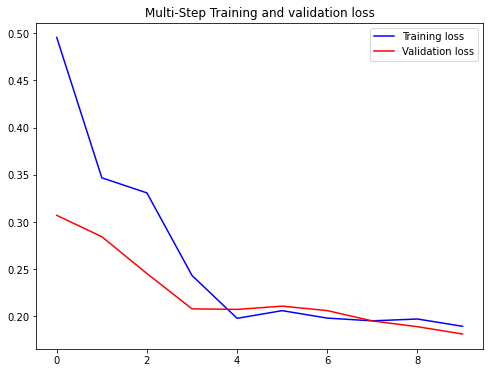

In [49]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

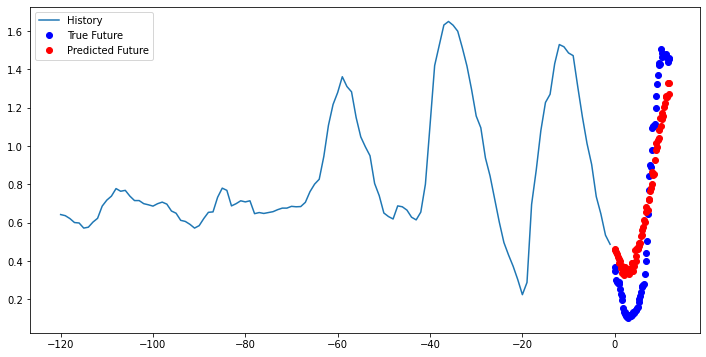

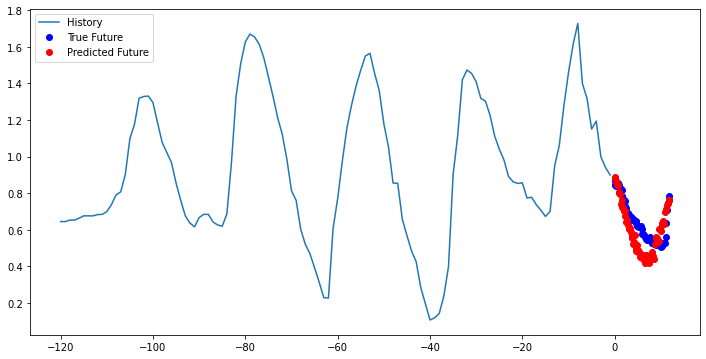

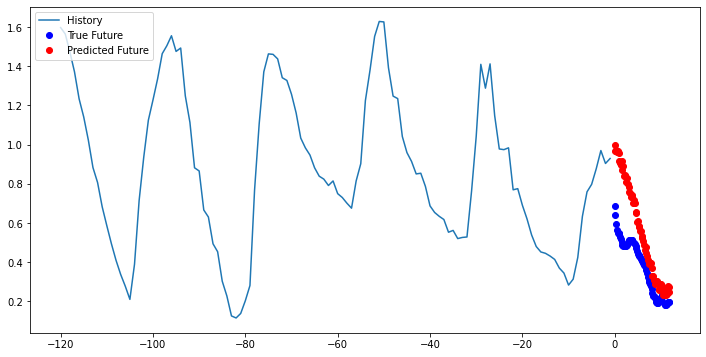

In [50]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).